**Data Architecture project** \
Master's degree course in Computer Science \
University of Milan - Bicocca \
A.Y. 2023-2024 \
\
Cavaleri Matteo - 875050 \
Gargiulo Elio - 869184 \
Piacente Cristian - 866020

# Needed libraries

In [1]:
# Import librerie

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import load_model
from scikeras.wrappers import KerasRegressor

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, make_scorer
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.inspection import PartialDependenceDisplay

from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit, LearningCurveDisplay
from sklearn.inspection import permutation_importance

from tensorflow import keras

import joblib

import shap

from IPython.display import HTML

import ultraimport, os

get_predictions = ultraimport(f"{os.getcwd()}/../ml_pipeline/utils/predictions.py", "get_predictions")

# Importing

## Datasets

In [2]:
# Datasets

datasets_folder = "../ml_pipeline/datasets"

df = pd.read_csv(datasets_folder + "/winetype.csv") # Raw dataset
preprocessed_df = pd.read_csv(datasets_folder + "/winetype_cleaned.csv") # Preprocessed dataset
transformed_df = pd.read_csv(datasets_folder + "/winetype_transformed.csv") # Transformed dataset
pca_df = pd.read_csv(datasets_folder + "/winetype_pca.csv") # PCA dataset
pca_train_df = pd.read_csv(datasets_folder + "/winetype_pca_train.csv") # Training set after PCA
pca_test_df = pd.read_csv(datasets_folder + "/winetype_pca_test.csv") # Test set after PCA

In [3]:
# Preview of the raw dataset
df.head()

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  white            7.0              0.27         0.36            20.7   
1  white            6.3              0.30         0.34             1.6   
2  white            8.1              0.28         0.40             6.9   
3  white            7.2              0.23         0.32             8.5   
4  white            7.2              0.23         0.32             8.5   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.045                 45.0                 170.0   1.0010  3.00   
1      0.049                 14.0                 132.0   0.9940  3.30   
2      0.050                 30.0                  97.0   0.9951  3.26   
3      0.058                 47.0                 186.0   0.9956  3.19   
4      0.058                 47.0                 186.0   0.9956  3.19   

   sulphates  alcohol  quality  
0       0.45      8.8        6  
1       0.49      9.5        6  
2       0.44     10.1        6  
3       0.40      9.9        6  
4       0.40      9.9        6

In [4]:
# Raw dataset shape
df.shape

(6497, 13)

In [5]:
# Preprocessed dataset shape
preprocessed_df.shape

(5295, 13)

In [6]:
# Preview of the transformed dataset
transformed_df.head()

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  True            7.0              0.27         0.36            20.7   
1  True            6.3              0.30         0.34             1.6   
2  True            8.1              0.28         0.40             6.9   
3  True            7.2              0.23         0.32             8.5   
4  True            6.2              0.32         0.16             7.0   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.045                 45.0                 170.0   1.0010  3.00   
1      0.049                 14.0                 132.0   0.9940  3.30   
2      0.050                 30.0                  97.0   0.9951  3.26   
3      0.058                 47.0                 186.0   0.9956  3.19   
4      0.045                 30.0                 136.0   0.9949  3.18   

   sulphates  alcohol  
0       0.45      8.8  
1       0.49      9.5  
2       0.44     10.1  
3       0.40      9.9  
4       0.47      9.6

In [7]:
# Preview of the PCA dataset
pca_df.head()

type       PC1       PC2       PC3       PC4       PC5
0  True  2.385803  3.556633 -0.781881 -1.306777  0.863415
1  True -0.024193 -0.438798 -0.354319  0.017424 -0.259395
2  True  0.211773  0.496292  0.397478 -0.451681  0.495517
3  True  1.779368  0.950267 -0.377411 -0.135596 -0.266892
4  True  0.731664  0.083277 -1.161927 -0.644412 -0.369434

In [8]:
# Training set shape
pca_train_df.shape

(4236, 6)

In [9]:
# Test set shape
pca_test_df.shape

(1059, 6)

## Models

In [10]:
# Models

models_folder = "../ml_pipeline/models"

nn_model_naive = load_model(models_folder + "/nn_model.h5") # Neural Network model
history_naive = joblib.load(models_folder + "/nn_history.pkl") # Neural Network history
svm_model_naive = joblib.load(models_folder + "/svm_model.pkl") # SVM
dtc_model_naive = joblib.load(models_folder + "/dtc_model.pkl") # Decision Tree

# Exploratory Data Analysis

## Quality drop

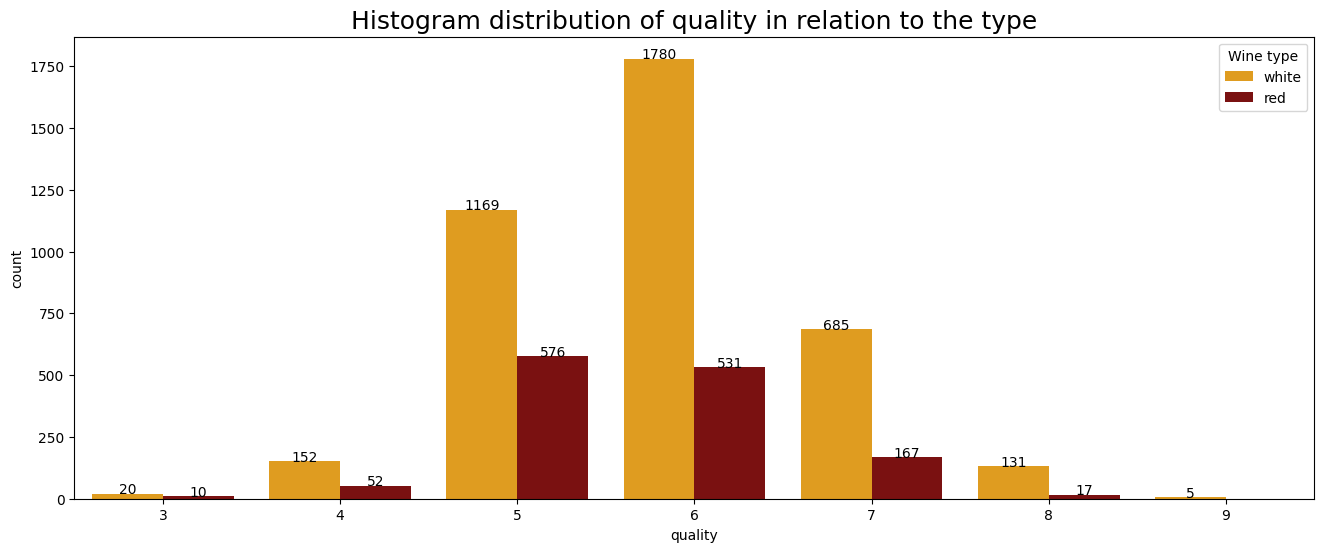

In [11]:
# Histogram distribution of quality in relation to the type

plt.figure(figsize=(16, 6))
plt.title("Histogram distribution of quality in relation to the type", size=18)
ax = sns.countplot(x=preprocessed_df['quality'], hue=preprocessed_df['type'], data=preprocessed_df, palette=['orange', 'darkred'])
plt.legend(title='Wine type', labels=['white', 'red'])

for p in ax.patches:
    height = int(p.get_height())
    if height > 0:
        ax.text(p.get_x() + p.get_width()/2., height + 1, height, ha="center")

plt.show()

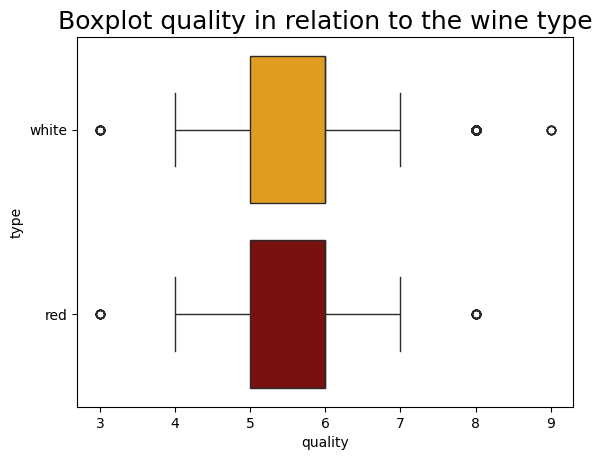

In [12]:
# Boxplot which can tell us that we can drop the feature quality
# It means that after this block we won't consider the preprocessed dataset anymore (the transformed one instead)

plt.title("Boxplot quality in relation to the wine type", size=18)
ax = sns.boxplot(x=preprocessed_df["quality"], y=preprocessed_df["type"], hue=preprocessed_df['type'], data=preprocessed_df, orient='h', palette=['orange', 'darkred'])
ax.set_yticks([0, 1])
ax.set_yticklabels(['white', 'red'])
plt.show()

## Statistics

Statistics without separating the two wine classes

In [13]:
transformed_df.describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    5295.000000       5295.000000  5295.000000     5295.000000   
mean        7.218008          0.344021     0.318782        5.051029   
std         1.320690          0.168237     0.147112        4.500641   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.240000        1.800000   
50%         7.000000          0.300000     0.310000        2.700000   
75%         7.700000          0.410000     0.400000        7.500000   
max        15.900000          1.580000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  5295.000000          5295.000000           5295.000000  5295.000000   
mean      0.056690            30.046837            114.118225     0.994536   
std       0.036901            17.827151             56.787187     0.002969   
min       0.009000             1.000000              6.000000     0.987110   
25%       0.038000            16.000000             74.000000     0.992200   
50%       0.047000            28.000000            116.000000     0.994670   
75%       0.066000            41.000000            154.000000     0.996780   
max       0.611000           289.000000            440.000000     1.038980   

                pH    sulphates      alcohol  
count  5295.000000  5295.000000  5295.000000  
mean      3.224385     0.533199    10.550154  
std       0.160155     0.149851     1.186533  
min       2.720000     0.220000     8.000000  
25%       3.110000     0.430000     9.500000  
50%       3.210000     0.510000    10.400000  
75%       3.330000     0.600000    11.400000  
max       4.010000     2.000000    14.900000

In [14]:
# Skewness of the features

transformed_df.iloc[:, 1:].skew()

fixed acidity           1.648811
volatile acidity        1.510289
citric acid             0.486635
residual sugar          1.707607
chlorides               5.343378
free sulfur dioxide     1.363486
total sulfur dioxide    0.063036
density                 0.666396
pH                      0.396474
sulphates               1.814488
alcohol                 0.545721
dtype: float64

In [15]:
# Kurtosis of the features

transformed_df.iloc[:, 1:].kurtosis()

fixed acidity            4.581830
volatile acidity         2.885402
citric acid              2.597669
residual sugar           7.049446
chlorides               48.283734
free sulfur dioxide      9.511998
total sulfur dioxide    -0.299378
density                  8.709492
pH                       0.446455
sulphates                8.634370
alcohol                 -0.539457
dtype: float64

Red wines statistics

In [16]:
# Sub-dataframe with only red wines
red_df = transformed_df[transformed_df['type'] == False]

red_df.describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1353.000000       1353.000000  1353.000000     1353.000000   
mean        8.318477          0.529294     0.273016        2.522986   
std         1.736520          0.183323     0.195585        1.354667   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.100000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.430000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1353.000000          1353.000000           1353.000000  1353.000000   
mean      0.088163            15.854398             46.822986     0.996715   
std       0.049463            10.418830             33.432546     0.001870   
min       0.012000             1.000000              6.000000     0.990070   
25%       0.070000             7.000000             22.000000     0.995600   
50%       0.079000            14.000000             38.000000     0.996700   
75%       0.091000            21.000000             63.000000     0.997830   
max       0.611000            72.000000            289.000000     1.003690   

                pH    sulphates      alcohol  
count  1353.000000  1353.000000  1353.000000  
mean      3.309165     0.658374    10.428394  
std       0.154938     0.170917     1.081636  
min       2.740000     0.330000     8.400000  
25%       3.210000     0.550000     9.500000  
50%       3.310000     0.620000    10.200000  
75%       3.400000     0.730000    11.100000  
max       4.010000     2.000000    14.900000

White wines statistics

In [17]:
# Sub-dataframe with only white wines
white_df = transformed_df[transformed_df['type'] == True]

white_df.describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    3942.000000       3942.000000  3942.000000     3942.000000   
mean        6.840297          0.280430     0.334490        5.918721   
std         0.866067          0.103256     0.122404        4.861389   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.300000          0.210000     0.270000        1.600000   
50%         6.800000          0.260000     0.320000        4.700000   
75%         7.300000          0.328750     0.390000        8.875000   
max        14.200000          1.100000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  3942.000000          3942.000000           3942.000000  3942.000000   
mean      0.045887            34.918062            137.215753     0.993788   
std       0.023088            17.227540             43.128509     0.002907   
min       0.009000             2.000000              9.000000     0.987110   
25%       0.035000            23.000000            106.000000     0.991600   
50%       0.042000            33.000000            133.000000     0.993500   
75%       0.050000            45.000000            166.000000     0.995710   
max       0.346000           289.000000            440.000000     1.038980   

                pH    sulphates      alcohol  
count  3942.000000  3942.000000  3942.000000  
mean      3.195287     0.490236    10.591945  
std       0.151345     0.113653     1.217787  
min       2.720000     0.220000     8.000000  
25%       3.090000     0.410000     9.500000  
50%       3.180000     0.480000    10.400000  
75%       3.290000     0.550000    11.400000  
max       3.820000     1.080000    14.200000

## Plots

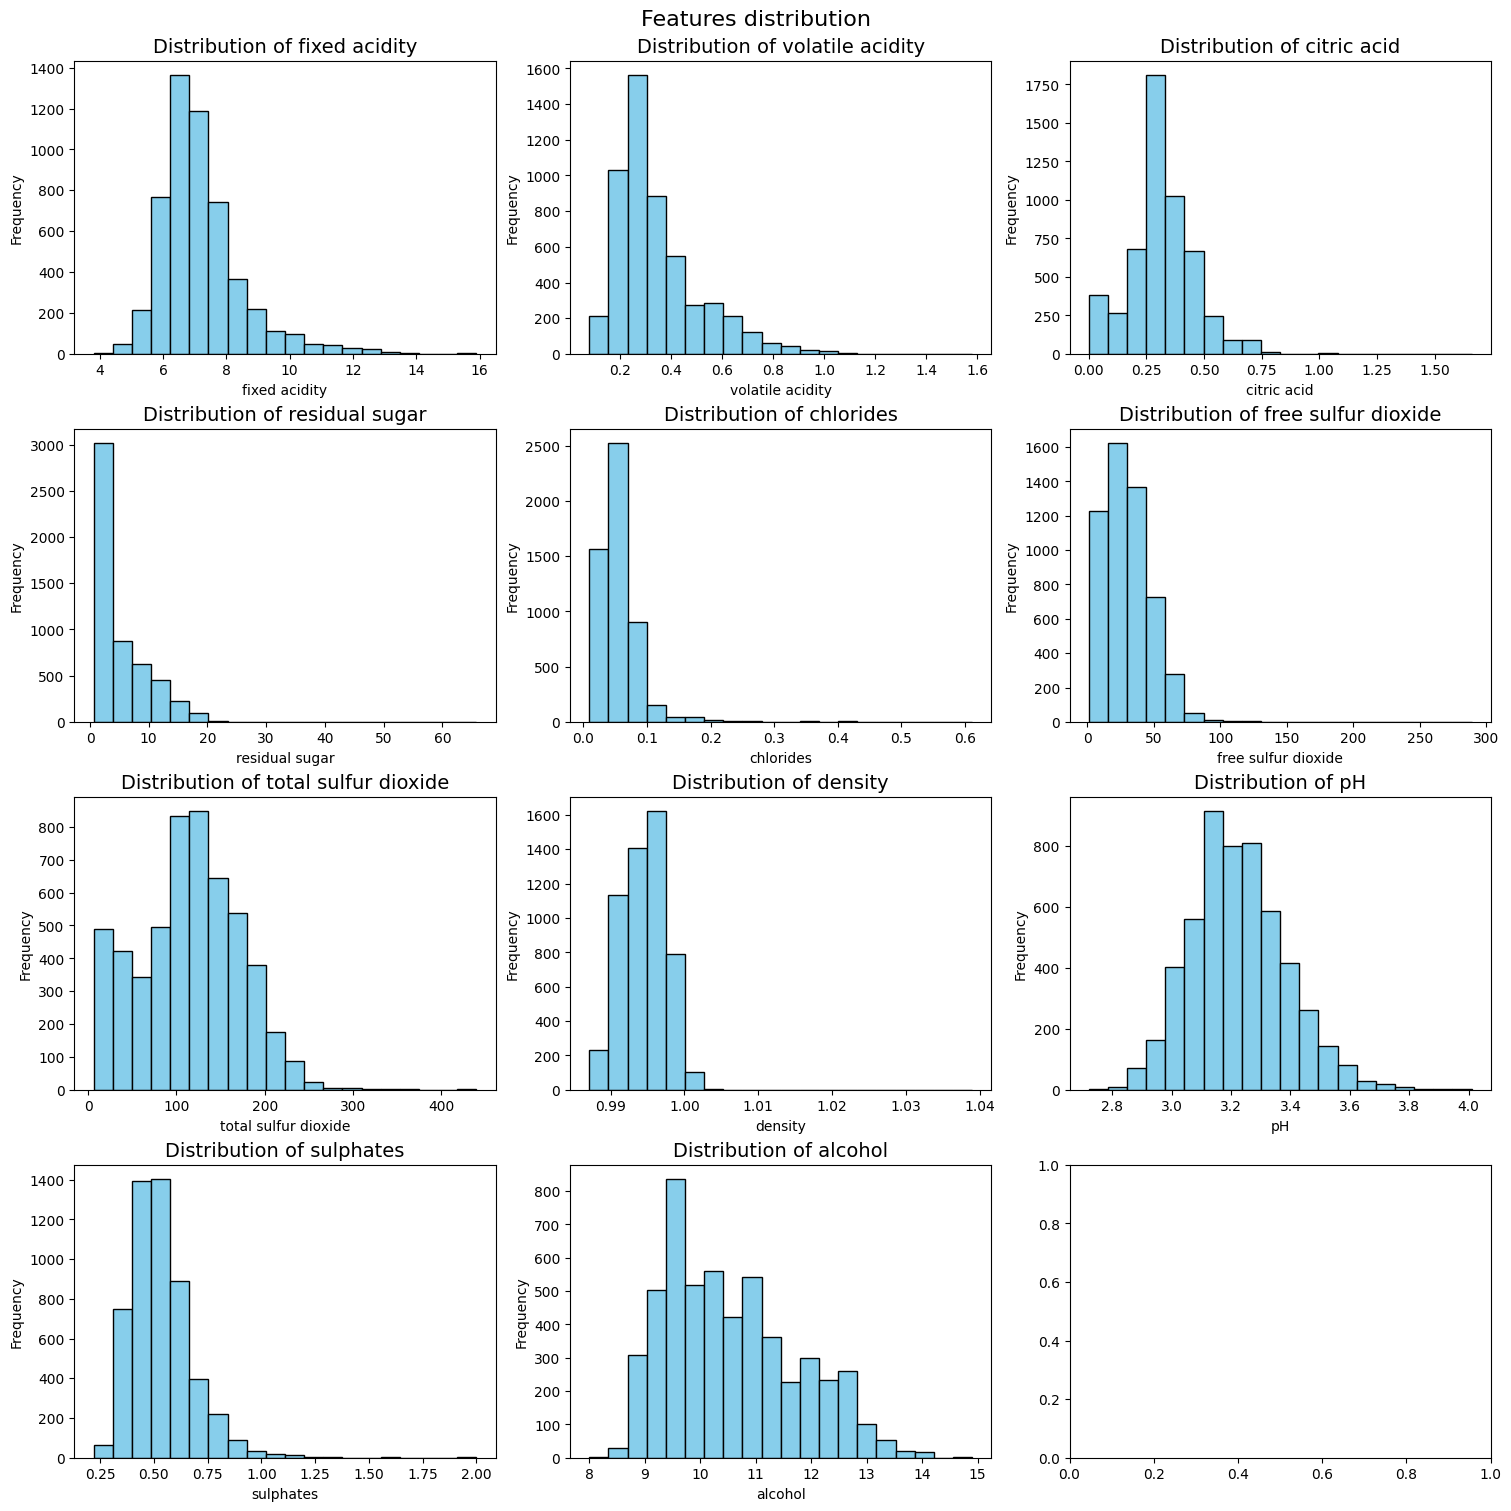

In [18]:
# Features distribution

(row, col) = (0, 0)

fig, axs = plt.subplots(4, 3, figsize=(15, 15), constrained_layout = True)

fig.suptitle('Features distribution', fontsize=16)

for i in range(1, 12):
    ax = axs[row, col]

    col = (col + 1) % 3
    if col == 0:
        row += 1

    column = transformed_df[transformed_df.columns[i]]

    ax.hist(column, bins=20, color='skyblue', edgecolor='black')

    ax.set_title('Distribution of ' + transformed_df.columns[i], fontsize=14)

    ax.set_xlabel(transformed_df.columns[i])
    ax.set_ylabel('Frequency')

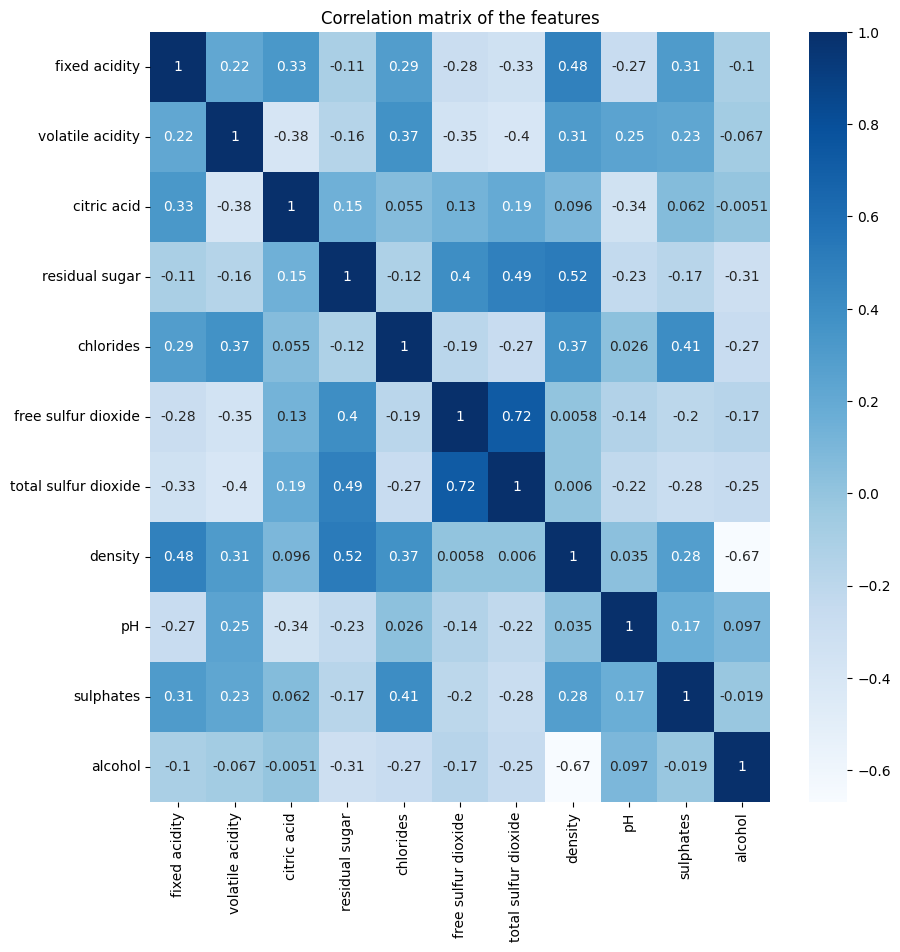

In [19]:
# Correlation matrix of the features

corr_matrix = transformed_df.iloc[:, 1:].corr() # the target is excluded

plt.figure(figsize=(10,10))
plt.title("Correlation matrix of the features")
sns.heatmap(corr_matrix, annot = True, cmap = 'Blues');

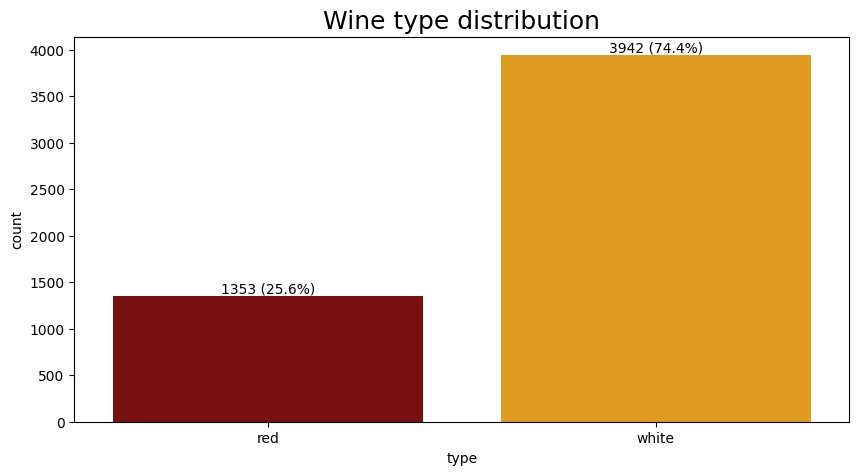

In [20]:
# Target distribution

plt.figure(figsize=(10, 5))
plt.title("Wine type distribution", size=18)
ax = sns.countplot(x=transformed_df['type'], hue=transformed_df['type'], palette=['darkred', 'orange'])

ax.set_xticks([0, 1])
ax.set_xticklabels(['red', 'white'])

plt.legend().set_visible(False)

total = len(transformed_df["type"])
for p in ax.patches:
    height = int(p.get_height())
    if height > 0:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        ax.text(p.get_x() + p.get_width()/2., height + 30, str(height) + ' (' + str(percentage) + ')', ha="center")

plt.show()

# EDA with Principal Component Analysis


In [21]:
# Features indexes
indexes = list(range(1, 12))
features = [transformed_df.columns[i] for i in indexes]
print('Features: ', features)

# Standardize the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(transformed_df[features])

# PCA
pca = PCA().fit(scaled_data)

Features:  ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


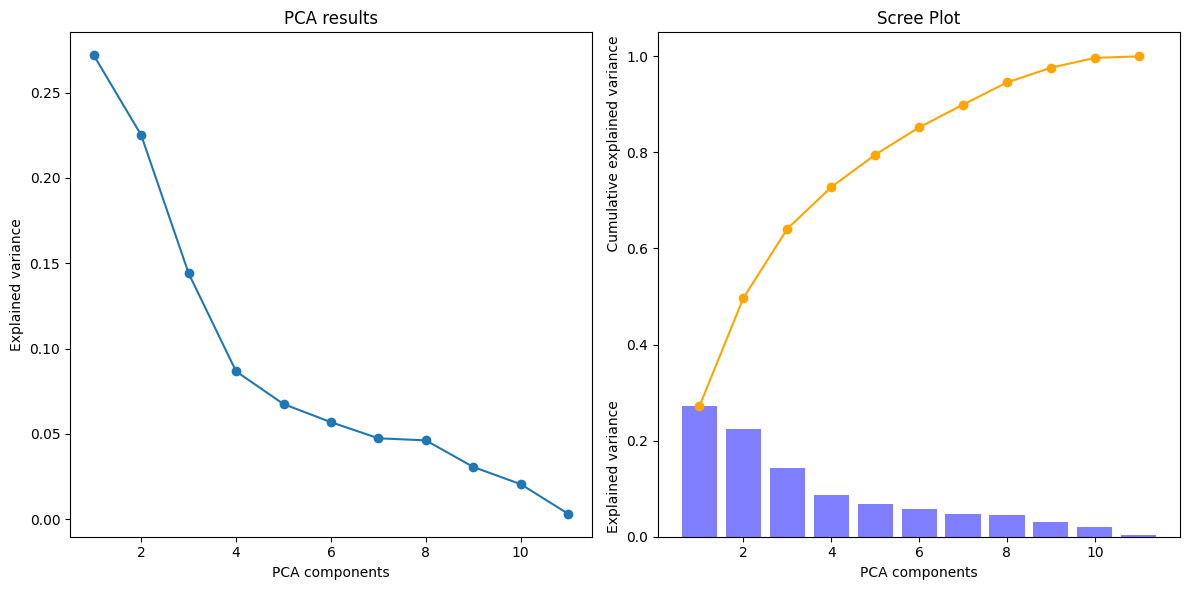

In [22]:
# Explained variance for each component
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, marker='o')
plt.xlabel('PCA components')
plt.ylabel('Explained variance')
plt.title("PCA results")

# Cumulative variance and scree plot
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.subplot(1, 2, 2)
plt.bar(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, color='blue', alpha=0.5, align='center')
plt.plot(range(1, pca.n_components_ + 1), cumulative_variance, marker='o', color='orange')
plt.xlabel('PCA components')
plt.ylabel('Explained variance                                  Cumulative explained variance')
plt.title("Scree Plot")

plt.tight_layout()
plt.show()

In [23]:
# PCA with 5 components
pca = PCA(n_components=5).fit(scaled_data)
pca_data = pca_df.drop('type', axis=1).to_numpy() # Exploit the loaded PCA dataset without the target

In [24]:
# Eigenvales, variance percentages, cumulative variance percentage

eigen_values = pca.explained_variance_
variance_ratio = pca.explained_variance_ratio_ * 100
cumulative_ratio = variance_ratio.cumsum()

pca_results = pd.DataFrame({
    'Eigenvalue': eigen_values,
    'Variance Percentage': variance_ratio,
    'Cumulative Variance Percentage': cumulative_ratio
})
pca_results.index = ['Comp ' + str(i+1) for i in pca_results.index]

pca_results

Eigenvalue  Variance Percentage  Cumulative Variance Percentage
Comp 1    2.991077            27.186472                       27.186472
Comp 2    2.476404            22.508515                       49.694986
Comp 3    1.585096            14.407246                       64.102232
Comp 4    0.953458             8.666165                       72.768397
Comp 5    0.742378             6.747617                       79.516014

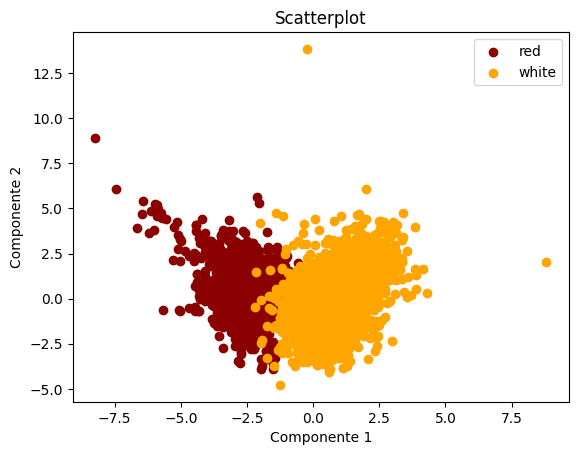

In [25]:
# Scatterplot

target_name = 'type'
unique_labels = np.unique(transformed_df[target_name])

fig, ax = plt.subplots()
for label in unique_labels:
    mask = (transformed_df[target_name] == label).values
    ax.scatter(pca_data[mask, 0], pca_data[mask, 1], color='darkred' if label == False else 'orange', label='red' if label == False else 'white')

ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')
ax.set_title('Scatterplot')

ax.legend()

plt.show()

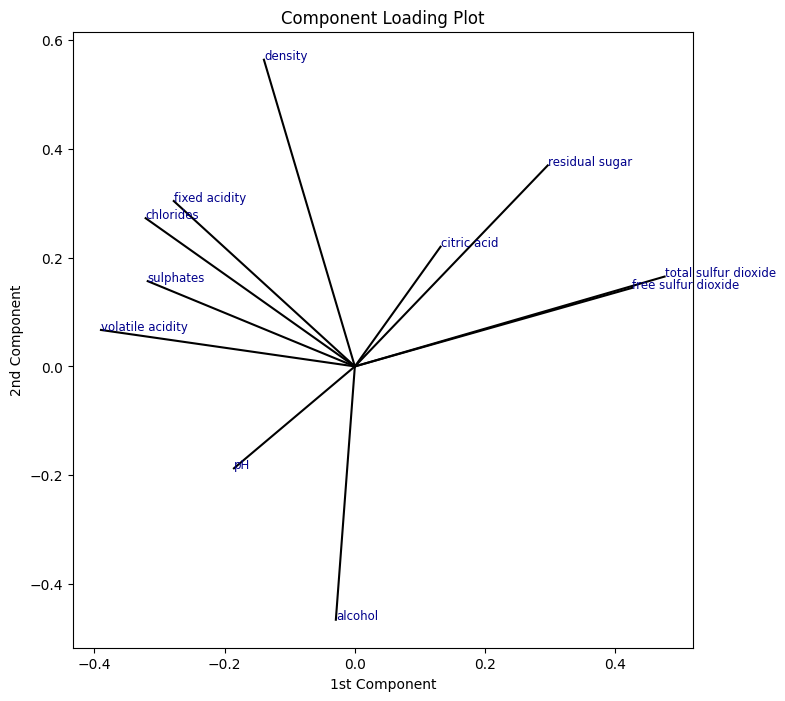

In [26]:
# Features correlation w.r.t the first two components

pcs = pca.components_
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()

for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    ax.plot([0, x], [0, y], color='k')
    ax.text(x, y, transformed_df.columns[indexes[i]], fontsize=8.5, color='darkblue')

ax.set_xlabel('1st Component')
ax.set_ylabel('2nd Component')
ax.set_title('Component Loading Plot')

plt.show()

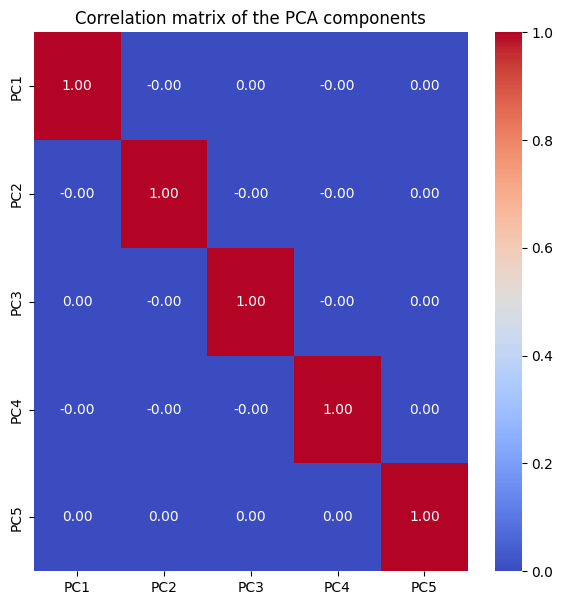

In [27]:
# Confirm there's no correlation in the PCA components

correlation_matrix = np.corrcoef(pca_data, rowvar=False)

plt.figure(figsize=(7,7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f",
            xticklabels=["PC1", "PC2", "PC3", "PC4", "PC5"],
            yticklabels=["PC1", "PC2", "PC3", "PC4", "PC5"])
plt.title('Correlation matrix of the PCA components')
plt.show()

# Models and evaluation

In [28]:
# Useful variables

X = pca_df.drop('type', axis=1).to_numpy()
y = pca_df['type']

X_train = pca_train_df.drop('type', axis=1)
y_train = pca_train_df['type']

X_test = pca_test_df.drop('type', axis=1)
y_test = pca_test_df['type']

## Baseline model

In [29]:
# Always predicting True (white), since it's the most prevalent class
y_pred_baseline = np.ones(len(X_test), dtype=bool)

### Confusion matrix and accuracy

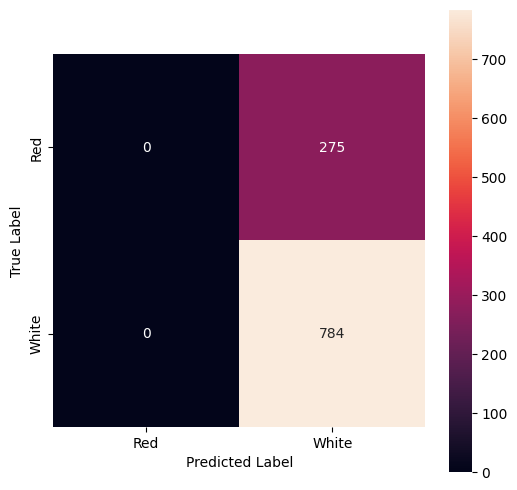

In [30]:
# Confusion matrix
# TN FP
# FN TP

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_baseline)

# Plot the confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True,
                        xticklabels=['Red', 'White'],
                        yticklabels=['Red', 'White'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label');

In [31]:
print("Accuracy baseline model\n")
baseline_test_accuracy = accuracy_score(y_test, y_pred_baseline)
print(baseline_test_accuracy)

Accuracy baseline model

0.7403210576015109


## Neural Network





### Training metrics

In [32]:
# Training loss and accuracy

print('Training loss:', history_naive['loss'][-1])
print('Training accuracy:', history_naive['accuracy'][-1])
nn_naive_train_accuracy = history_naive['accuracy'][-1]

Training loss: 0.1049489676952362
Training accuracy: 0.9819952845573425


### Test metrics and confusion matrix


In [33]:
# Evaluate the model
score_naive = nn_model_naive.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score_naive[0])
print('Test accuracy:', score_naive[1])
nn_naive_test_accuracy = score_naive[1]

Test loss: 0.10834470391273499
Test accuracy: 0.9830028414726257


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


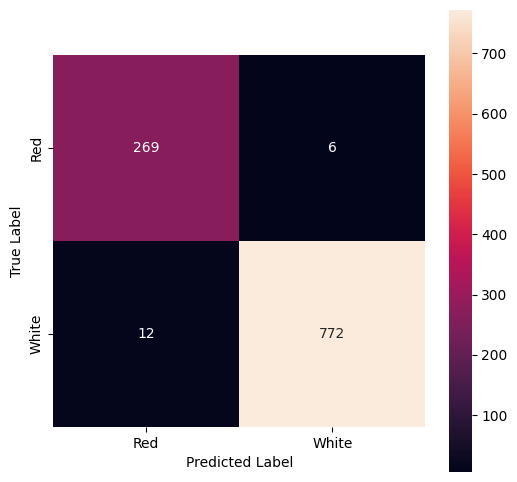

In [34]:
# Perform the predictions
y_pred_nn = get_predictions(nn_model_naive, X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_nn)

# Plot the confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True,
                        xticklabels=['Red', 'White'],
                        yticklabels=['Red', 'White'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label');

### Classification report

In [35]:
# Classification report

nn_naive_classification_report = classification_report(y_test, y_pred_nn)
print(nn_naive_classification_report)

              precision    recall  f1-score   support

       False       0.96      0.98      0.97       275
        True       0.99      0.98      0.99       784

    accuracy                           0.98      1059
   macro avg       0.97      0.98      0.98      1059
weighted avg       0.98      0.98      0.98      1059



### ROC curve and AUC


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step


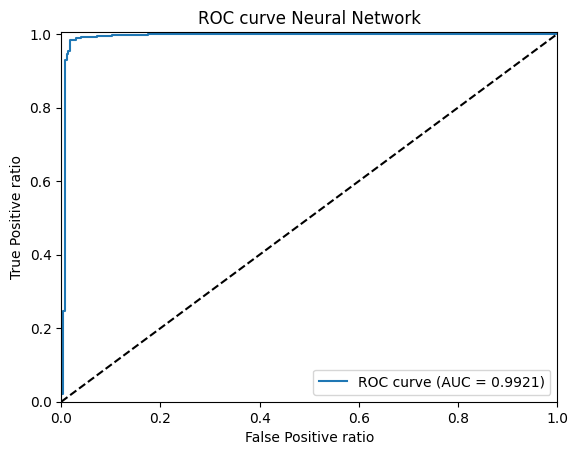

In [36]:
# Predictions without the rounding
y_pred_prob_nn = nn_model_naive.predict(X_test)

# ROC curve
fpr_nn_naive, tpr_nn_naive, _ = roc_curve(y_test, y_pred_prob_nn)

# Calculate the AUC
roc_auc_nn_naive = roc_auc_score(y_test, y_pred_prob_nn)

# Plot the ROC curve
plt.plot(fpr_nn_naive, tpr_nn_naive, label='ROC curve (AUC = %0.4f)' % roc_auc_nn_naive)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel('False Positive ratio')
plt.ylabel('True Positive ratio')
plt.title('ROC curve Neural Network')
plt.legend(loc="lower right")
plt.show()

### Learning curves

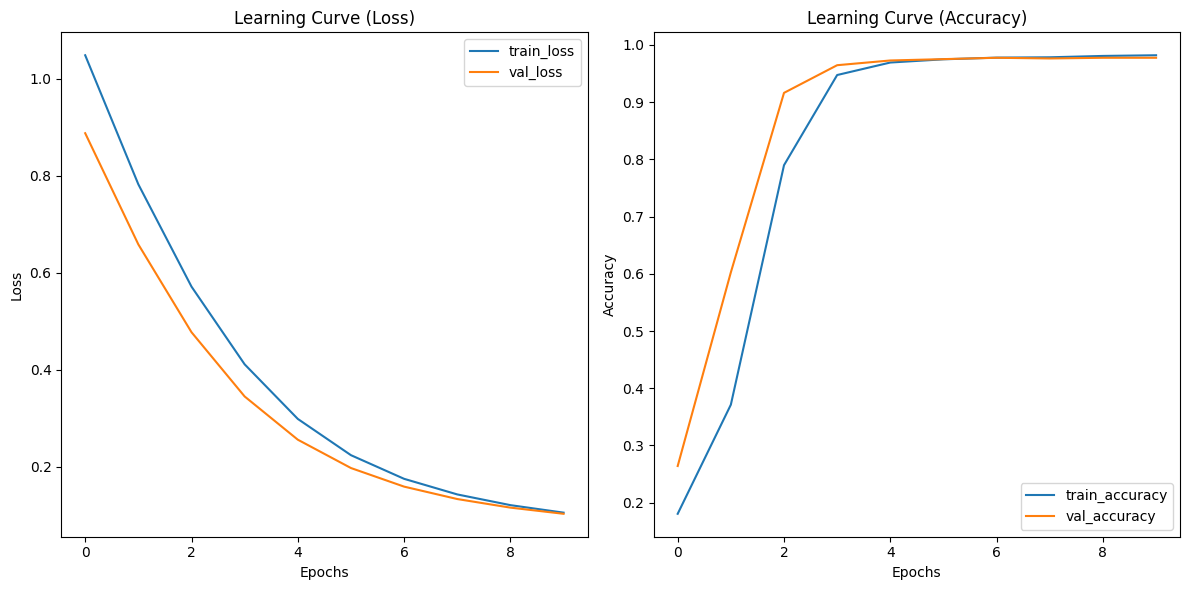

In [37]:
# Plot loss and accuracy
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot loss
axes[0].plot(history_naive['loss'], label='train_loss')
axes[0].plot(history_naive['val_loss'], label='val_loss')
axes[0].set_title('Learning Curve (Loss)')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot accuracy
axes[1].plot(history_naive['accuracy'], label='train_accuracy')
axes[1].plot(history_naive['val_accuracy'], label='val_accuracy')
axes[1].set_title('Learning Curve (Accuracy)')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

## SVM





### Training metrics

In [38]:
# Training loss and accuracy

y_pred_svm_train = get_predictions(svm_model_naive, X_train)
print('Training accuracy:', accuracy_score(y_train, y_pred_svm_train))
svm_naive_train_accuracy = accuracy_score(y_train, y_pred_svm_train)

Training accuracy: 0.9848914069877243


### 3D plot (of the 5 dimensions model)

In [39]:
# PCA with 3 components, since we can't plot more than 3 dimensions

pca_train_3D = PCA(n_components=3).fit(X_train)
X_train_3D = pca_train_3D.transform(X_train)

w: [ 2.09652048 -0.31618019  0.15466576]
w_hat: [ 0.98619779 -0.14873034  0.07275437]
b: 2.2122
Hyperplane: 2.0965 * x -0.3162 * y + 0.1547 * z + 2.2122 = 0
Margin magnitude: 0.4704


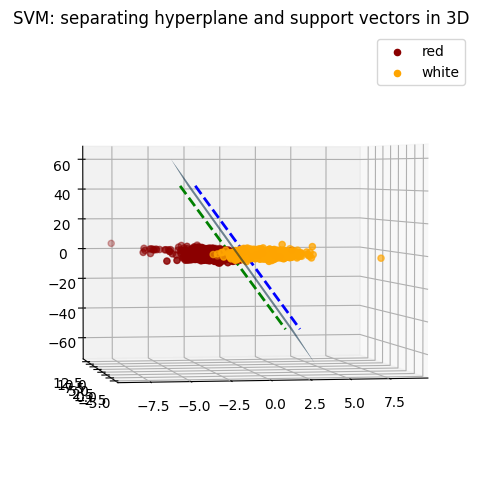

In [40]:
# In 3D the hyperplane is given by
# w_0 * x + w_1 * y + w_2 * z + b = 0
# So we have z = (-b - w_0 * x - w_1 * y) / w_2
w = svm_model_naive.coef_[0]
w = w[:-2] # from shape (5,) to (3,)
w_hat = w / (np.sqrt(np.sum(w ** 2)))
b = svm_model_naive.intercept_[0]
hyperplane = lambda x,y: (-b - w[0] * x - w[1] * y) / w[2]
print('w:', w)
print('w_hat:', w_hat) # unit vector giving the hyperplane direction
print('b:', round(b, 4))
print("Hyperplane:", round(w[0], 4), "* x", round(w[1], 4), "* y +", round(w[2], 4), "* z +", round(b, 4), "= 0")

# 3D figure
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
plt.title('SVM: separating hyperplane and support vectors in 3D')

# Hyperplane
xx = np.linspace(-5, 3)
tmp_x, tmp_y = np.meshgrid(xx, xx)
z = hyperplane(tmp_x, tmp_y)
ax.plot_surface(tmp_x, tmp_y, z, alpha=0.8)

# Points corresponding to the support vectors
yy = xx
zz = hyperplane(xx, yy)

# Margin and support vectors
margin = 1 / np.sqrt(np.sum(w ** 2))
print('Margin magnitude:', round(margin, 4))
decision_boundary_points = np.array(list(zip(xx, yy, zz)))
points_of_line_above = decision_boundary_points + w_hat * margin
points_of_line_below = decision_boundary_points - w_hat * margin

# Plot support vectors
ax.plot(points_of_line_above[:, 0],
        points_of_line_above[:, 1],
        points_of_line_above[:, 2],
        'b--', linewidth=2)
ax.plot(points_of_line_below[:, 0],
        points_of_line_below[:, 1],
        points_of_line_below[:, 2],
        'g--', linewidth=2)

# 3D training data
ax.scatter(X_train_3D[y_train == False, 0], X_train_3D[y_train == False, 1], X_train_3D[y_train == False, 2], c='darkred', label='red')
ax.scatter(X_train_3D[y_train == True, 0], X_train_3D[y_train == True, 1], X_train_3D[y_train == True, 2], c='orange', label='white')

# Show the plot
ax.view_init(2, 260)
ax.legend()
plt.show()

### Test metrics and confusion matrix


In [41]:
# Evaluate the model
y_pred_svm = get_predictions(svm_model_naive, X_test)
print('Test accuracy:', accuracy_score(y_test, y_pred_svm))
svm_naive_test_accuracy = accuracy_score(y_test, y_pred_svm)

Test accuracy: 0.9858356940509915


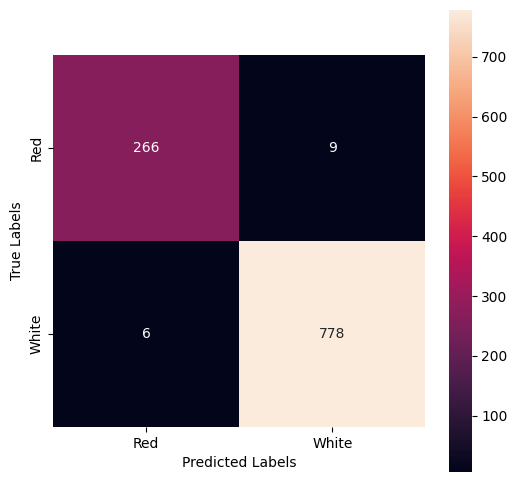

In [42]:
# Confusion matrix
# TN FP
# FN TP

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)

# Plot the confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True,
                        xticklabels=['Red', 'White'],
                        yticklabels=['Red', 'White'])
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels');

### Classification report

In [43]:
# Classification report

svm_naive_classification_report = classification_report(y_test, y_pred_svm)
print(svm_naive_classification_report)

              precision    recall  f1-score   support

       False       0.98      0.97      0.97       275
        True       0.99      0.99      0.99       784

    accuracy                           0.99      1059
   macro avg       0.98      0.98      0.98      1059
weighted avg       0.99      0.99      0.99      1059



### ROC curve and AUC


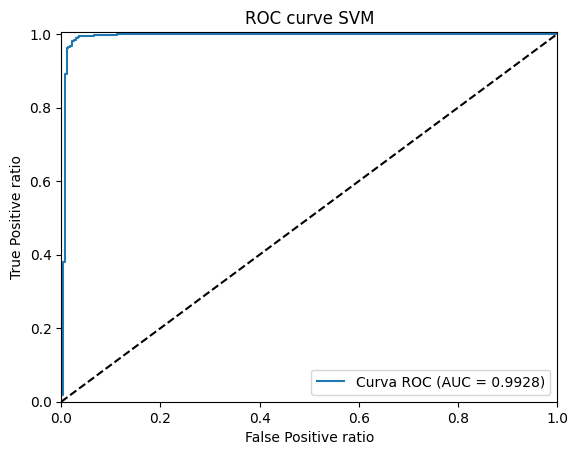

In [44]:
# Probability of the predictions
prob_svm_model = svm.SVC(kernel='linear', random_state=42, probability=True)
estimator_svm_prob = prob_svm_model.fit(X_train, y_train)
y_pred_proba_svm = prob_svm_model.predict_proba(X_test)
y_pred_prob_svm = y_pred_proba_svm[:, 1]

# ROC curve
fpr_svm_naive, tpr_svm_naive, _ = roc_curve(y_test, y_pred_prob_svm)

# Calculate the AUC
roc_auc_svm_naive = roc_auc_score(y_test, y_pred_prob_svm)

# Plot the ROC curve
plt.plot(fpr_svm_naive, tpr_svm_naive, label='Curva ROC (AUC = %0.4f)' % roc_auc_svm_naive)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel('False Positive ratio')
plt.ylabel('True Positive ratio')
plt.title('ROC curve SVM')
plt.legend(loc="lower right")
plt.show()

### Learning curves

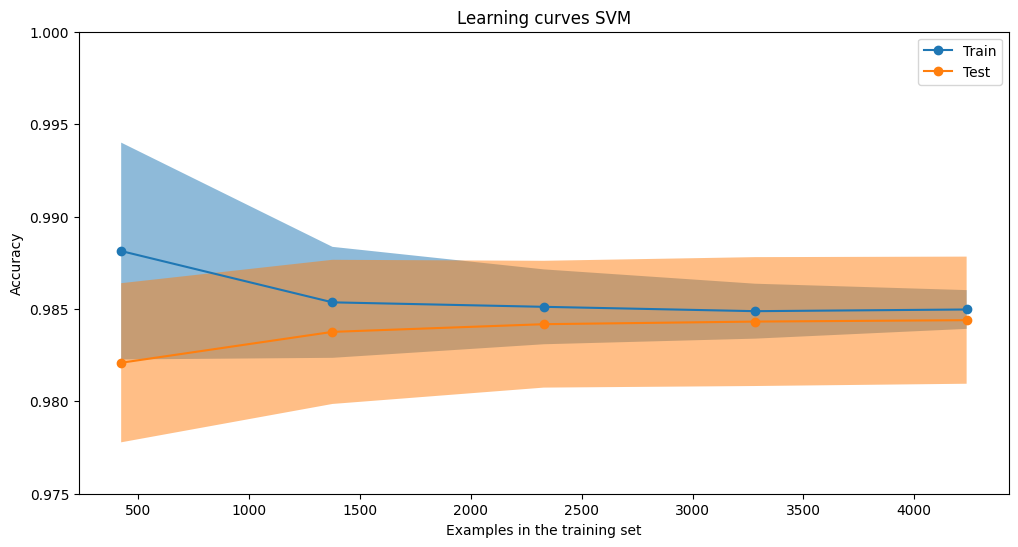

In [45]:
# Learning curves SVM

fig, axes = plt.subplots(1, 1, figsize=(12, 6))

common_params = {
    "X": X,
    "y": y,
    "cv": ShuffleSplit(n_splits=100, test_size=0.2, random_state=42),
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "score_name": "Accuracy",
    "score_type": "both"
}

LearningCurveDisplay.from_estimator(svm_model_naive, **common_params, ax=axes)

axes.set_ylim([0.975, 1.0])

axes.set_xlabel("Examples in the training set")

axes.set_title("Learning curves SVM")

plt.show()

## Decision Tree





### Training metrics

In [46]:
# Training loss and accuracy

y_pred_dtc_train = get_predictions(dtc_model_naive, X_train)
print('Training accuracy:', accuracy_score(y_train, y_pred_dtc_train))
dtc_naive_train_accuracy = accuracy_score(y_train, y_pred_dtc_train)

Training accuracy: 0.9995278564683664


### Plots

In [47]:
# Plot the Decision Tree
fig, ax = plt.subplots(figsize=(150, 100))
plot_tree(dtc_model_naive, filled=True, ax=ax)
plt.plot()

[]

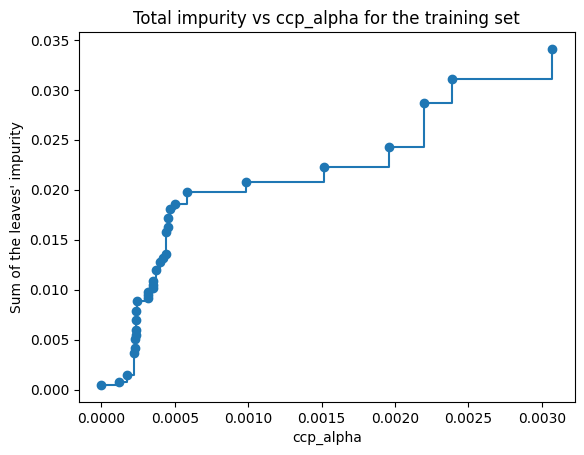

In [48]:
# Plot impurity vs ccp_alpha

path = dtc_model_naive.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("ccp_alpha")
ax.set_ylabel("Sum of the leaves' impurity")
ax.set_title("Total impurity vs ccp_alpha for the training set");

In [49]:
# The highest ccp_alpha, corresponding to the tree with only the root

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42,ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

print("Nodes in the tree: {} with ccp_alpha: {} and depth: {}".format(
clfs[-1].tree_.node_count, ccp_alphas[-1], clfs[-1].tree_.max_depth))

Nodes in the tree: 1 with ccp_alpha: 0.34535359013689576 and depth: 0


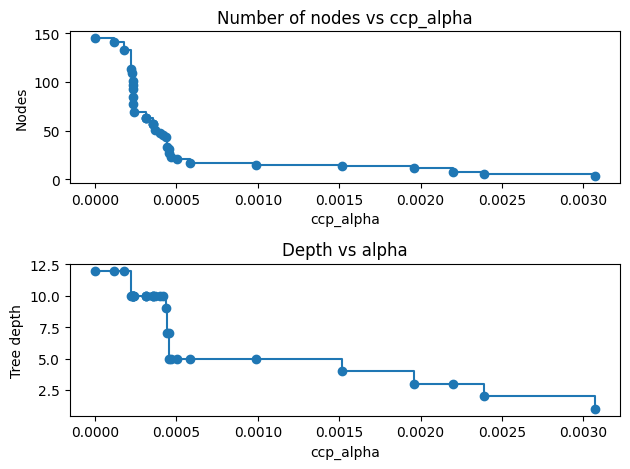

In [50]:
# Plots number of nodes vs ccp_alpha and depth vs alpha

node_counts = [clf.tree_.node_count for clf in clfs[:-1]]
depth = [clf.tree_.max_depth for clf in clfs[:-1]]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas[:-1], node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("ccp_alpha")
ax[0].set_ylabel("Nodes")
ax[0].set_title("Number of nodes vs ccp_alpha")
ax[1].plot(ccp_alphas[:-1], depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("ccp_alpha")
ax[1].set_ylabel("Tree depth")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

### Test metrics and confusion matrix


In [51]:
# Evaluate the model
y_pred_dtc = get_predictions(dtc_model_naive, X_test)
print('Test accuracy:', accuracy_score(y_test, y_pred_dtc))
dtc_naive_test_accuracy = accuracy_score(y_test, y_pred_dtc)

Test accuracy: 0.9782813975448537


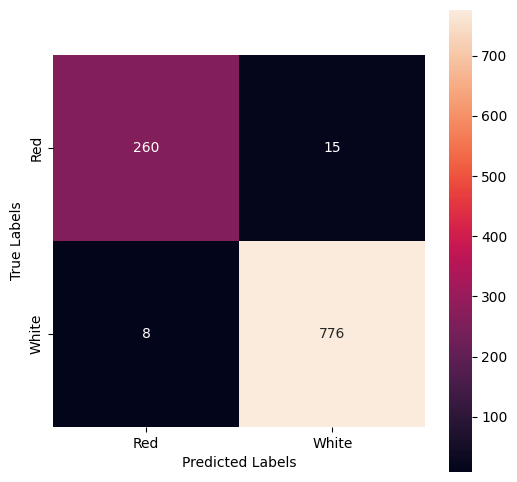

In [52]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_dtc)

# Plot the confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True,
                        xticklabels=['Red', 'White'],
                        yticklabels=['Red', 'White'])
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels');

### Classification report

In [53]:
# Classification report

dtc_naive_classification_report = classification_report(y_test, y_pred_dtc)
print(dtc_naive_classification_report)

              precision    recall  f1-score   support

       False       0.97      0.95      0.96       275
        True       0.98      0.99      0.99       784

    accuracy                           0.98      1059
   macro avg       0.98      0.97      0.97      1059
weighted avg       0.98      0.98      0.98      1059



### ROC curve and AUC


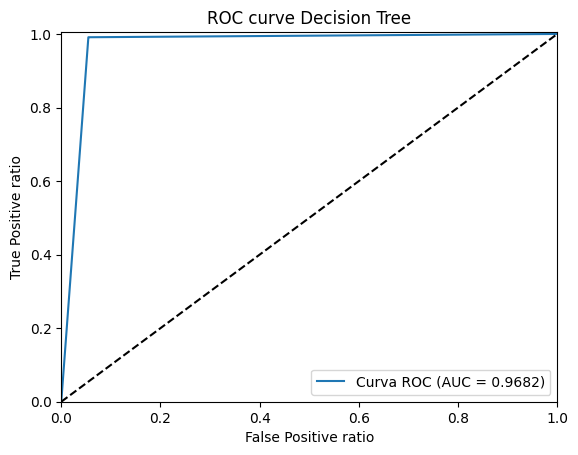

In [54]:
# Probability of the predictions
y_pred_proba_dtc = dtc_model_naive.predict_proba(X_test)
y_pred_prob_dtc = y_pred_proba_dtc[:, 1]

# ROC curve
fpr_dtc_naive, tpr_dtc_naive, _ = roc_curve(y_test, y_pred_prob_dtc)

# Calculate the AUC
roc_auc_dtc_naive = roc_auc_score(y_test, y_pred_prob_dtc)

# Plot the ROC curve
plt.plot(fpr_dtc_naive, tpr_dtc_naive, label='Curva ROC (AUC = %0.4f)' % roc_auc_dtc_naive)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel('False Positive ratio')
plt.ylabel('True Positive ratio')
plt.title('ROC curve Decision Tree')
plt.legend(loc="lower right")
plt.show()

### Learning curves

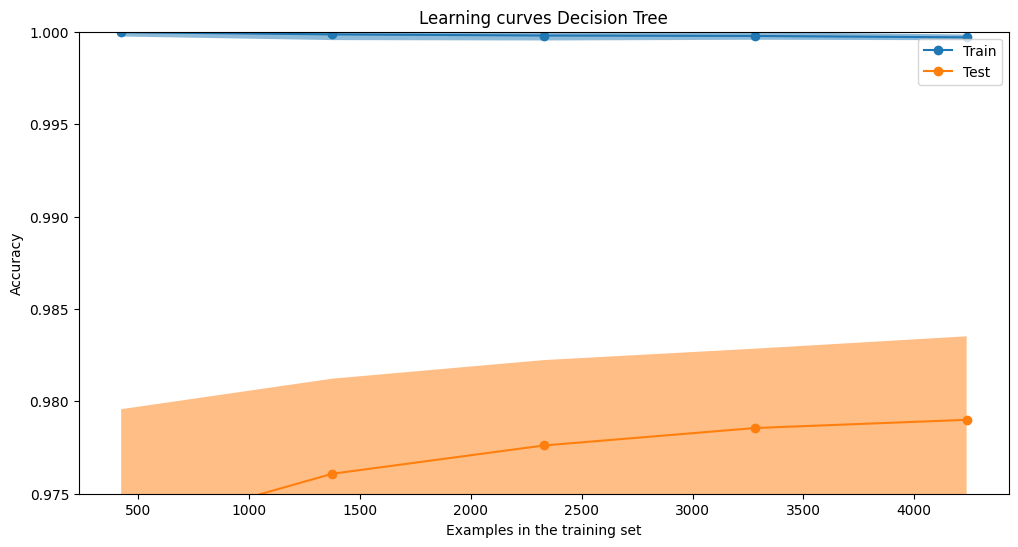

In [55]:
# Learning curves Decision Tree

fig, axes = plt.subplots(1, 1, figsize=(12, 6))

common_params = {
    "X": X,
    "y": y,
    "cv": ShuffleSplit(n_splits=100, test_size=0.2, random_state=42),
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "score_name": "Accuracy",
    "score_type": "both"
}

LearningCurveDisplay.from_estimator(dtc_model_naive, **common_params, ax=axes)

axes.set_ylim([0.975, 1.0])

axes.set_xlabel("Examples in the training set")

axes.set_title("Learning curves Decision Tree")

plt.show()

# Explainability

We can exploit both already created (from the PCA section) and new plots to explain:
- how the PCA space was created: PCA Scores, Component Loading Plot, Scree Plot
- how the classification is made by each model (Neural Network, SVM, Decision Tree): Correlation Features - Prediction, Variable Importance, Partial Dependence Plot, SHAP

In [56]:
# Init js
shap.initjs()

# Index used by SHAP to identify the chosen target class
shap_index = 1 # There are more white wines (1) than red (0)
nn_shap_index = 0 # For NN there is only one label

## PCA Scores

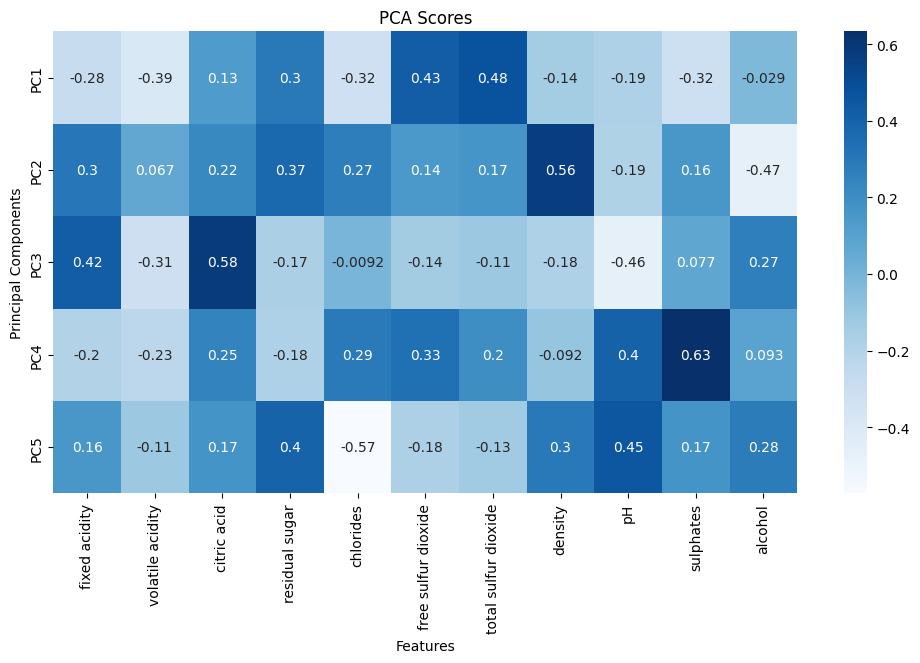

In [57]:
# Create a DataFrame to show the contribute of the features for each PCA component
components_df = pd.DataFrame(pca.components_, columns=transformed_df.columns[1:], index=[f'PC{i+1}' for i in range(pca.n_components)])

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(components_df, cmap='Blues', annot=True)
plt.title('PCA Scores')
plt.ylabel('Principal Components')
plt.xlabel('Features')
plt.show()

## Neural Network explainability

### Correlation Features - Prediction

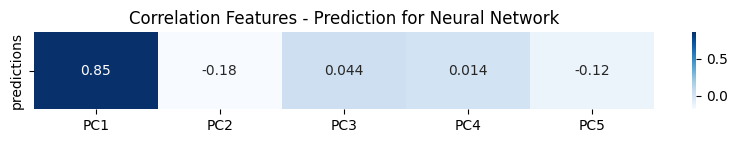

In [58]:
# Convert predictions to a DataFrame
predictions_df_nn = pd.DataFrame(y_pred_nn, columns=['predictions'])

# Combine predictions and features
combined_df_nn = pd.concat([predictions_df_nn, X_test], axis=1)

# Calculate correlations
correlation_matrix_nn = combined_df_nn.corr()

# Extract the row for the predictions
correlation_predictions_df_nn = correlation_matrix_nn.loc['predictions'].drop('predictions').to_frame().transpose()

# Plot the correlations
plt.figure(figsize=(10,1))
plt.title("Correlation Features - Prediction for Neural Network")
sns.heatmap(correlation_predictions_df_nn, annot = True, cmap = 'Blues');

### Variable Importance

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
34/34 ━━━━━━━━━━

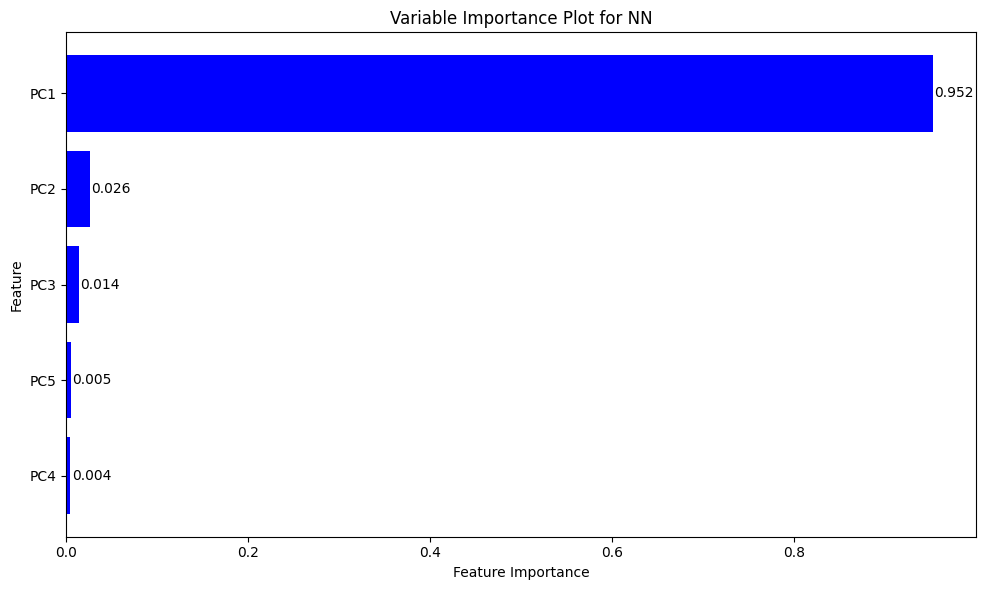

In [59]:
# Ensure model predictions are class labels, not probabilities
# Create a wrapper to convert model probabilities to class labels for scoring
class ClassifierWrapper:
    def __init__(self, model):
        self.model = model
    
    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return get_predictions(self.model, X)

# Wrap the model
wrapped_model_nn = ClassifierWrapper(nn_model_naive)

# Retrieve the importances using F1 score for better handling of imbalanced datasets
importances_nn = permutation_importance(wrapped_model_nn, X_test, y_test, scoring=make_scorer(f1_score))

# Normalize the importances
importance_sum_nn = importances_nn.importances_mean.sum()
normalized_importances_nn = importances_nn.importances_mean / importance_sum_nn

# Create a DataFrame for better visualization
importance_df_nn = pd.DataFrame({'Feature': X_test.columns, 'Importance': normalized_importances_nn})
importance_df_nn = importance_df_nn.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
bars_nn = plt.barh(importance_df_nn['Feature'], importance_df_nn['Importance'], color='blue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Variable Importance Plot for NN')
plt.gca().invert_yaxis()
plt.xlim(left=0)  # Ensure the bars start from the left edge

# Add text annotations for the feature importance values
for bar in bars_nn:
    width = bar.get_width()
    plt.gca().text(width + 0.002, bar.get_y() + bar.get_height() / 2, f'{width:.3f}', 
                   ha='left', va='center')

plt.tight_layout()
plt.show()

### Partial Dependence Plot

106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9844 - loss: 0.0777 - val_accuracy: 0.9800 - val_loss: 0.0743
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1

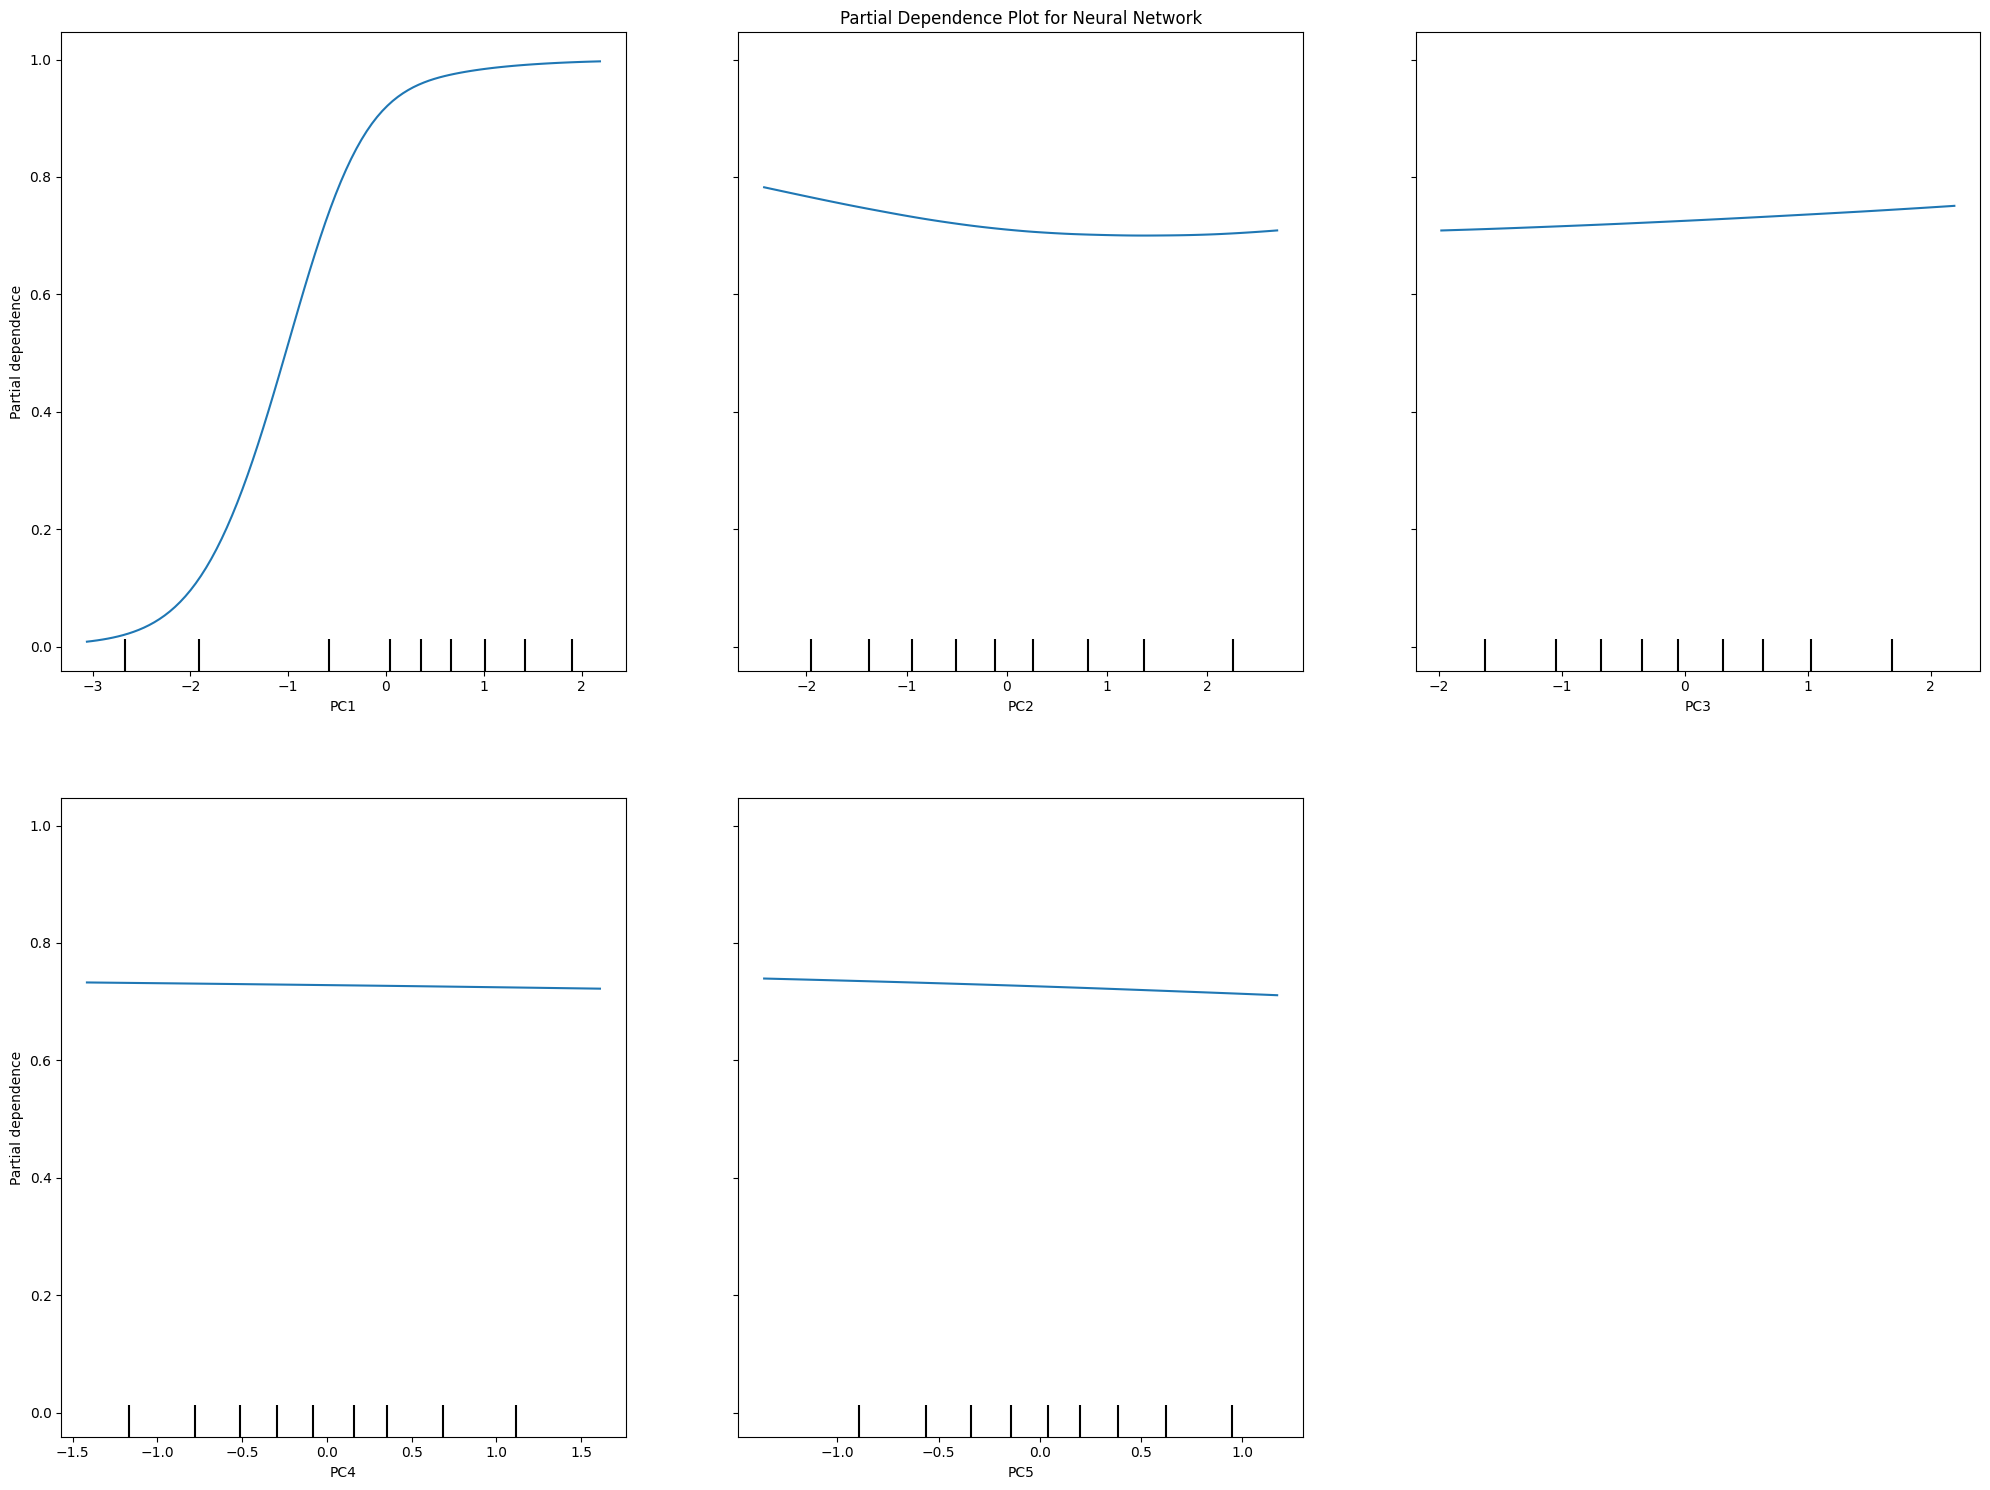

In [94]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 15))

# Re-compile the Neural Network just to be sure
nn_model_naive.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# An estimator for the Neural Network is needed in order to make the library work
estimator_nn = KerasRegressor(model=nn_model_naive, optimizer='adam')
estimator_nn.fit(X_train, y_train, epochs=1, validation_split=0.2)

PartialDependenceDisplay.from_estimator(estimator_nn, X_test, X_test.columns, ax=ax)
ax.set_title('Partial Dependence Plot for Neural Network')

plt.tight_layout()
plt.show()

### SHAP

In [96]:
# Create the SHAP explainer
explainer_nn = shap.KernelExplainer(nn_model_naive, shap.sample(X_train, 100))

# Calculate SHAP values
shap_values_nn = explainer_nn.shap_values(X_test)

  0%|          | 0/1059 [00:00<?, ?it/s]

100%|██████████| 1059/1059 [00:30<00:00, 34.74it/s]


In [97]:
# Force plot
force_plot_nn = shap.force_plot(explainer_nn.expected_value[nn_shap_index], shap_values_nn[..., nn_shap_index], X_test, link="logit")

# Show with a white background color to support any dark-themed IDE
HTML(f"<div style='background-color:white;'>{shap.getjs() + force_plot_nn.html()}</div>")

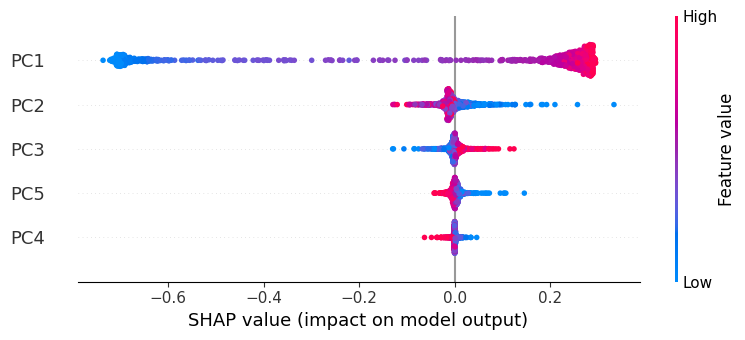

In [98]:
# Summary plot
shap.summary_plot(shap_values_nn[..., nn_shap_index], X_test)

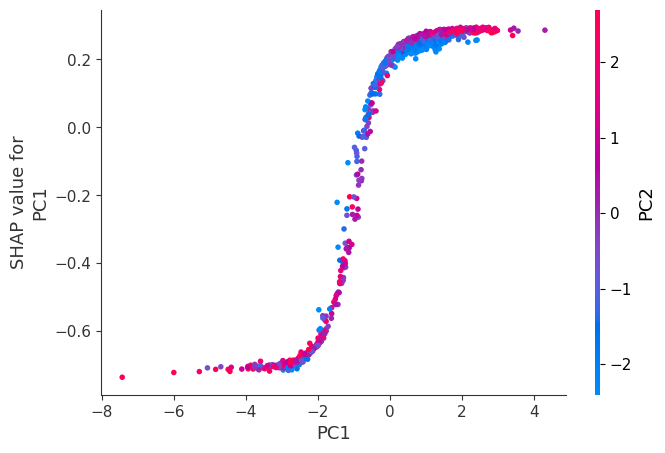

In [99]:
# Dependence plot between the feature PC1 and PC2
shap.dependence_plot(X_test.columns[0], shap_values_nn[..., nn_shap_index], X_test)

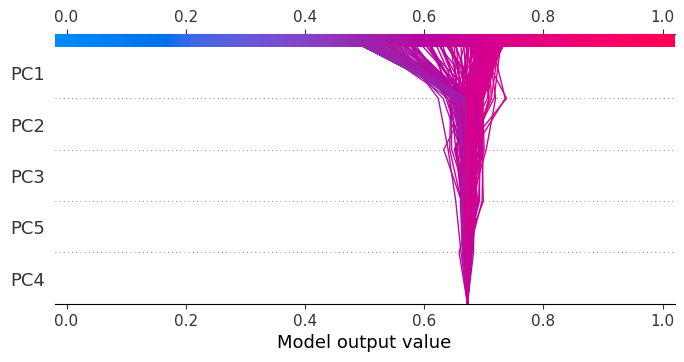

In [100]:
# Decision plot
shap.decision_plot(explainer_nn.expected_value[nn_shap_index], shap_values_nn[..., nn_shap_index], X_test, link="logit")

## SVM explainability

### Correlation Features - Prediction

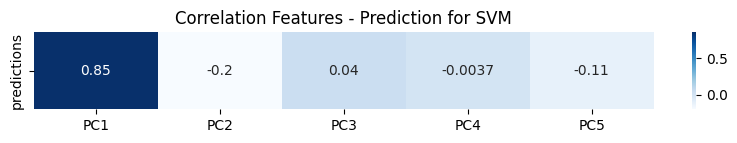

In [66]:
# Convert predictions to a DataFrame
predictions_df_svm = pd.DataFrame(y_pred_svm, columns=['predictions'])

# Combine predictions and features
combined_df_svm = pd.concat([predictions_df_svm, X_test], axis=1)

# Calculate correlations
correlation_matrix_svm = combined_df_svm.corr()

# Extract the row for the predictions
correlation_predictions_df_svm = correlation_matrix_svm.loc['predictions'].drop('predictions').to_frame().transpose()

# Plot the correlations
plt.figure(figsize=(10,1))
plt.title("Correlation Features - Prediction for SVM")
sns.heatmap(correlation_predictions_df_svm, annot = True, cmap = 'Blues');

### Variable Importance

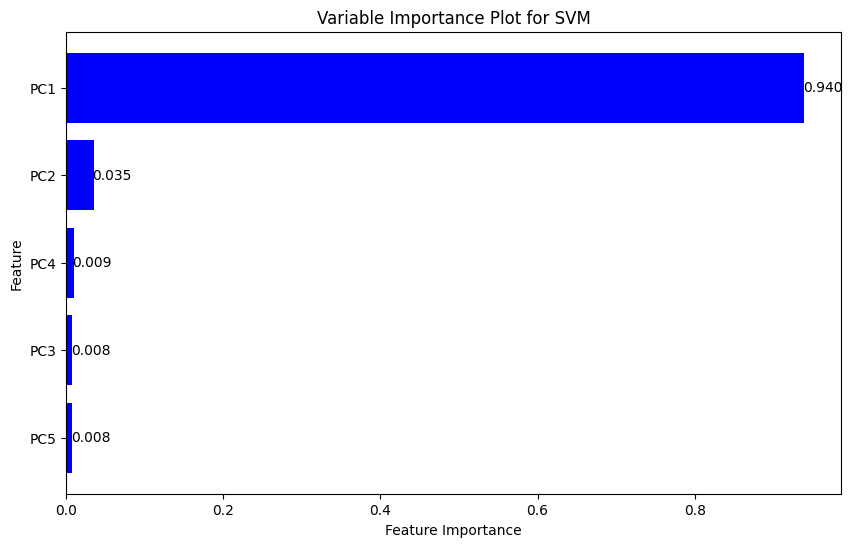

In [67]:
# Retrieve the importances
importances_svm = permutation_importance(svm_model_naive, X_test, y_test)

# Normalize the importances
importance_sum_svm = importances_svm.importances_mean.sum()
normalized_importances_svm = importances_svm.importances_mean / importance_sum_svm

# Create a DataFrame for better visualization
importance_df_svm = pd.DataFrame({'Feature': X_test.columns, 'Importance': normalized_importances_svm})
importance_df_svm = importance_df_svm.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
bars_svm = plt.barh(importance_df_svm['Feature'], importance_df_svm['Importance'], color='blue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Variable Importance Plot for SVM')
plt.gca().invert_yaxis()

# Add text annotations for the feature importance values
for bar in bars_svm:
    width = bar.get_width()
    plt.gca().text(width + 0.023, bar.get_y() + bar.get_height() / 2, f'{width:.3f}', 
                   ha='center', va='center')

plt.show()

### Partial Dependence Plot

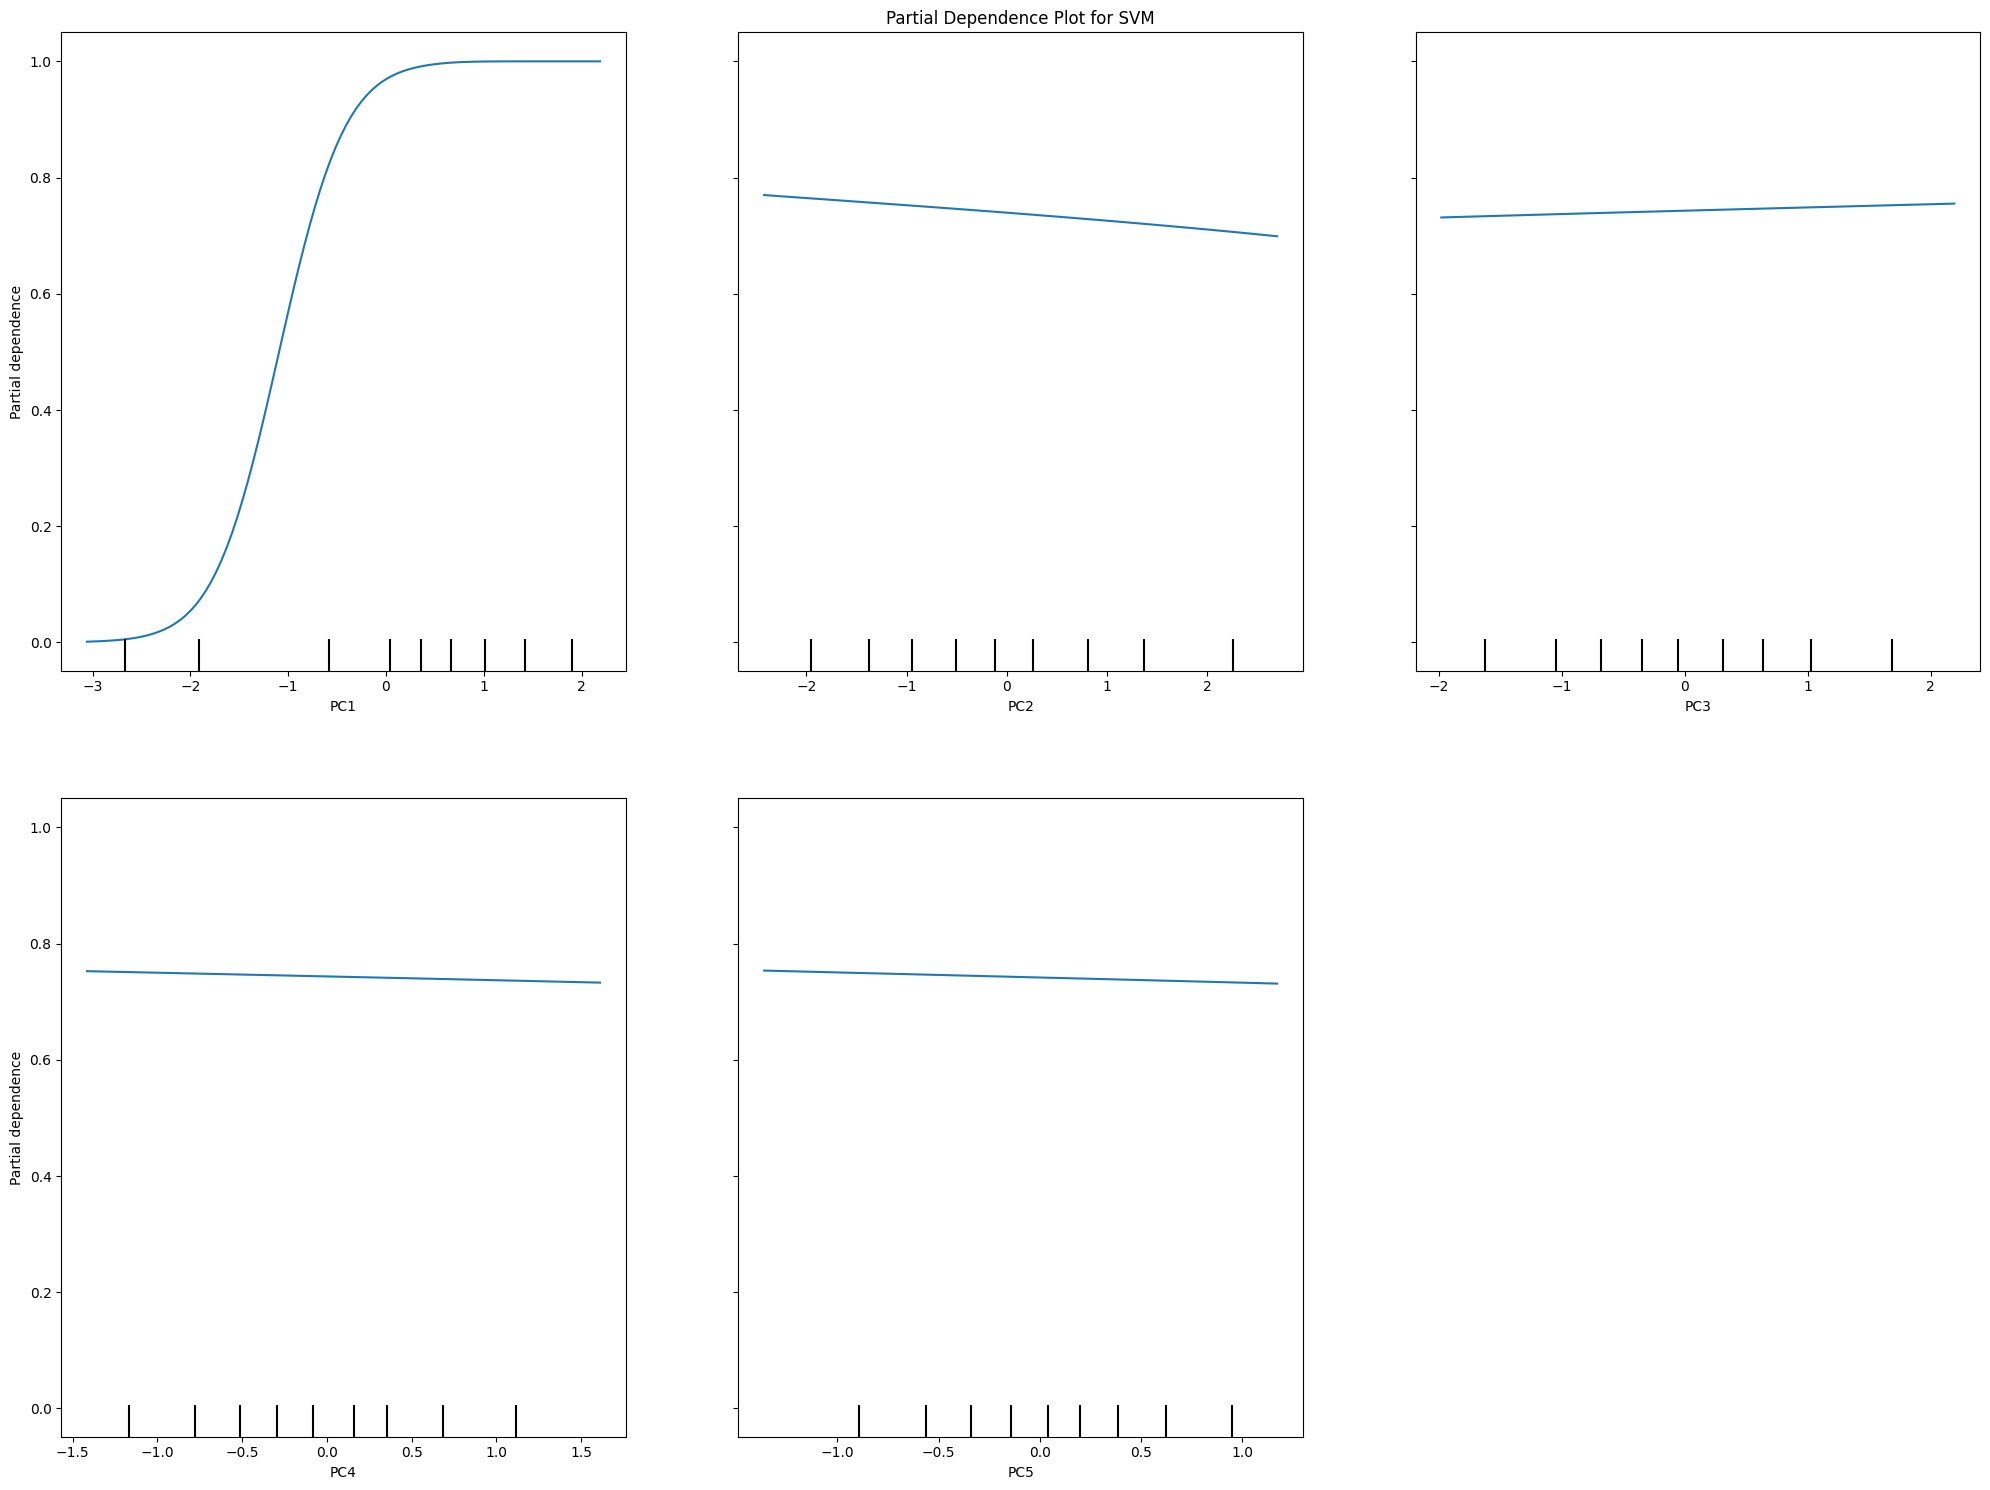

In [68]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 15))

PartialDependenceDisplay.from_estimator(prob_svm_model, X_test, X_test.columns, ax=ax)
ax.set_title('Partial Dependence Plot for SVM')

plt.tight_layout()
plt.show()

### SHAP

In [69]:
# Create a SHAP explainer
explainer_svm = shap.KernelExplainer(prob_svm_model.predict_proba, shap.sample(X_train, 100))

# Calculate SHAP values
shap_values_svm = explainer_svm.shap_values(X_test)

  0%|          | 0/1059 [00:00<?, ?it/s]

100%|██████████| 1059/1059 [00:29<00:00, 36.28it/s]


In [70]:
# Force plot
force_plot_svm = shap.force_plot(explainer_svm.expected_value[shap_index], shap_values_svm[..., shap_index], X_test, link="logit")

# Show with a white background color to support any dark-themed IDE
HTML(f"<div style='background-color:white;'>{shap.getjs() + force_plot_svm.html()}</div>")

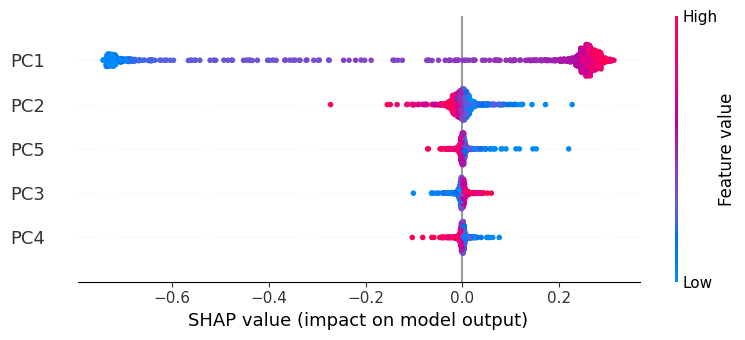

In [71]:
# Summary plot
shap.summary_plot(shap_values_svm[..., shap_index], X_test)

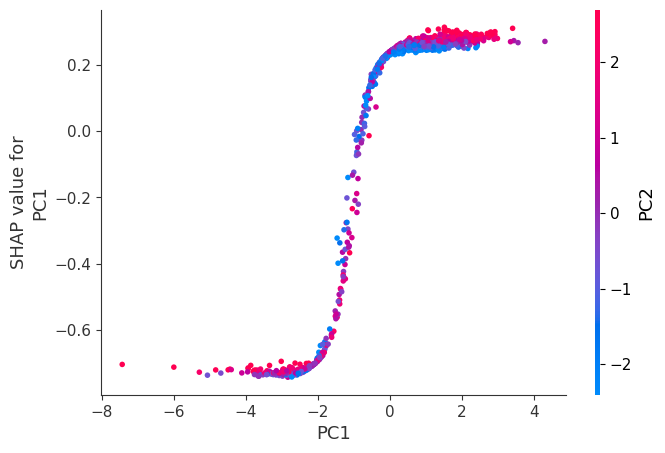

In [72]:
# Dependence plot between the feature PC1 and PC2
shap.dependence_plot(X_test.columns[0], shap_values_svm[..., shap_index], X_test)

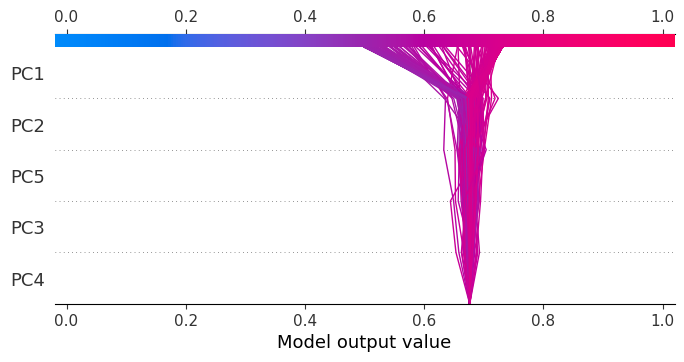

In [73]:
# Decision plot
shap.decision_plot(explainer_svm.expected_value[shap_index], shap_values_svm[..., shap_index], X_test, link="logit")

## Decision Tree explainability

### Correlation Features - Prediction

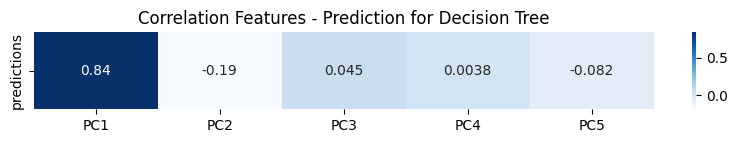

In [74]:
# Convert predictions to a DataFrame
predictions_df_dtc = pd.DataFrame(y_pred_dtc, columns=['predictions'])

# Combine predictions and features
combined_df_dtc = pd.concat([predictions_df_dtc, X_test], axis=1)

# Calculate correlations
correlation_matrix_dtc = combined_df_dtc.corr()

# Extract the row for the predictions
correlation_predictions_df_dtc = correlation_matrix_dtc.loc['predictions'].drop('predictions').to_frame().transpose()

# Plot the correlations
plt.figure(figsize=(10,1))
plt.title("Correlation Features - Prediction for Decision Tree")
sns.heatmap(correlation_predictions_df_dtc, annot = True, cmap = 'Blues');

### Variable Importance

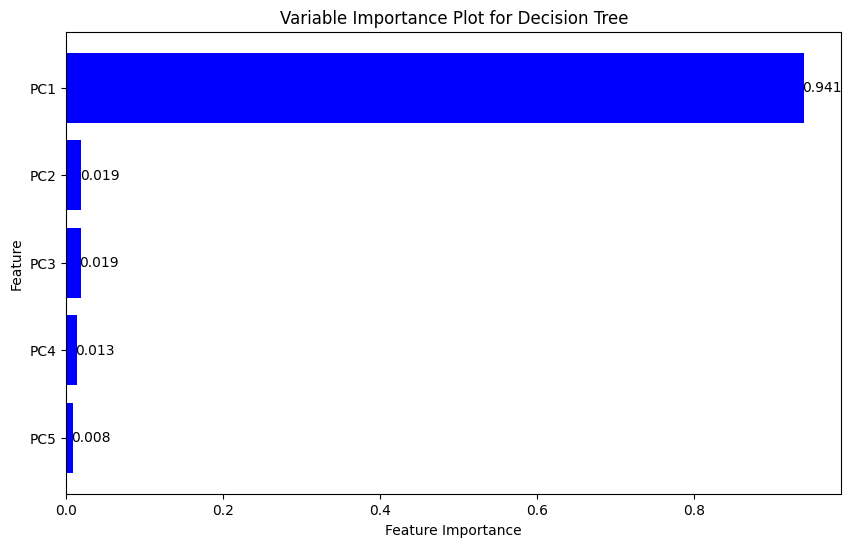

In [75]:
# Retrieve the importances
importances_dtc = dtc_model_naive.feature_importances_

# Create a DataFrame for better visualization
importance_df_dtc = pd.DataFrame({'Feature': X_test.columns, 'Importance': importances_dtc})
importance_df_dtc = importance_df_dtc.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
bars_dtc = plt.barh(importance_df_dtc['Feature'], importance_df_dtc['Importance'], color='blue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Variable Importance Plot for Decision Tree')
plt.gca().invert_yaxis()

# Add text annotations for the feature importance values
for bar in bars_dtc:
    width = bar.get_width()
    plt.gca().text(width + 0.023, bar.get_y() + bar.get_height() / 2, f'{width:.3f}', 
                   ha='center', va='center')

plt.show()

### Partial Dependence Plot 

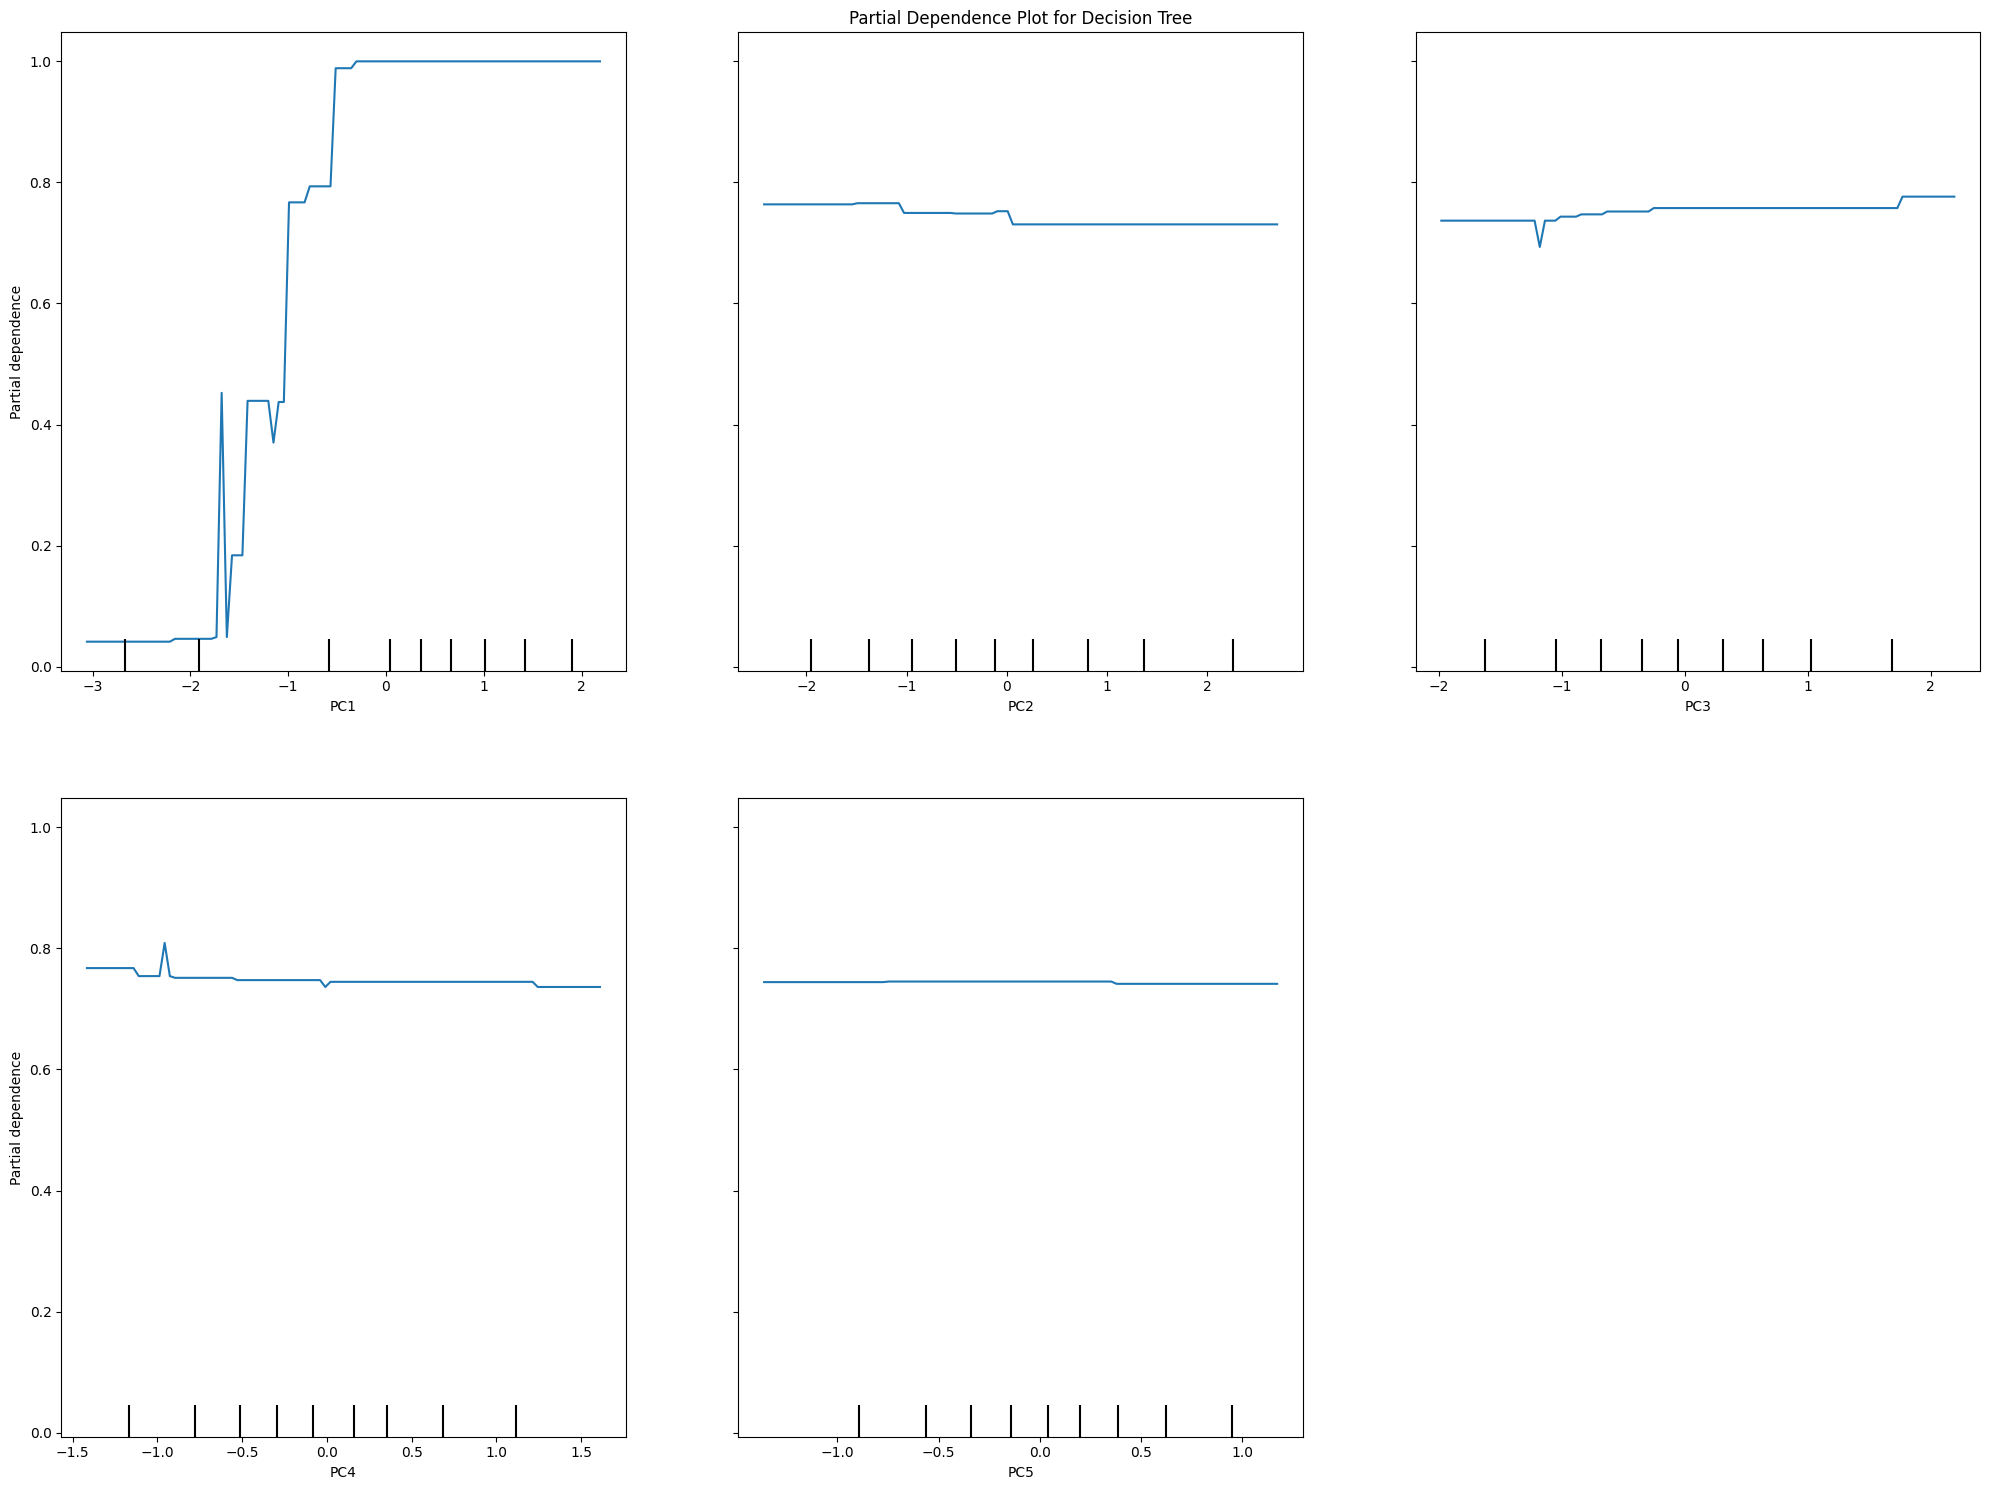

In [76]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 15))

PartialDependenceDisplay.from_estimator(dtc_model_naive, X_test, X_test.columns, ax=ax)
ax.set_title('Partial Dependence Plot for Decision Tree')

plt.tight_layout()
plt.show()

### SHAP

In [77]:
# Create a SHAP explainer
explainer_dtc = shap.KernelExplainer(dtc_model_naive.predict_proba, shap.sample(X_train, 100))

# Calculate SHAP values
shap_values_dtc = explainer_dtc.shap_values(X_test)

  0%|          | 0/1059 [00:00<?, ?it/s]

100%|██████████| 1059/1059 [00:20<00:00, 51.81it/s]


In [78]:
# Force plot
force_plot_dtc = shap.force_plot(explainer_dtc.expected_value[shap_index], shap_values_dtc[..., shap_index], X_test, link="logit")

# Show with a white background color to support any dark-themed IDE
HTML(f"<div style='background-color:white;'>{shap.getjs() + force_plot_dtc.html()}</div>")

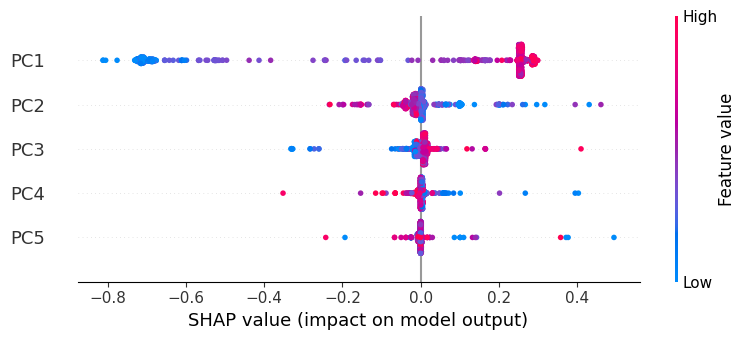

In [79]:
# Summary plot
shap.summary_plot(shap_values_dtc[..., shap_index], X_test)

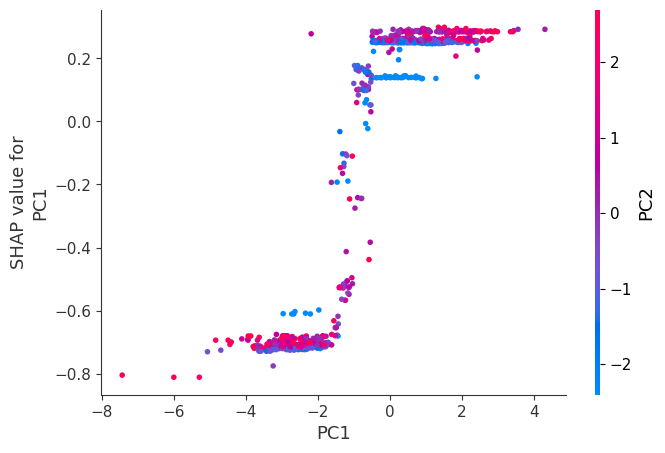

In [80]:
# Dependence plot between the feature PC1 and PC2
shap.dependence_plot(X_test.columns[0], shap_values_dtc[..., shap_index], X_test)

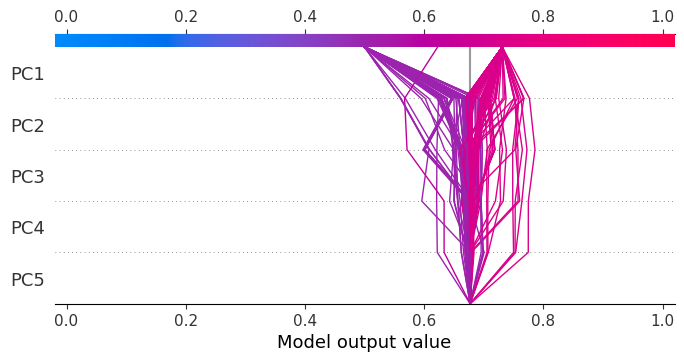

In [81]:
# Decision plot
shap.decision_plot(explainer_dtc.expected_value[shap_index], shap_values_dtc[..., shap_index], X_test, link="logit")